<img src="https://raw.githubusercontent.com/ICB-DCM/pyPESTO/master/doc/logo/logo_wordmark.png" width="40%" alt="pyPESTO logo"/>

# A Python Package for Parameter Estimation and Uncertainty Quantification

[PyPESTO](https://github.com/ICB-DCM/pyPESTO) is a a python package parameter inference. PyPESTO offers a unified interface to various optimization and sampling methods. 

As a design principle, pyPESTO is highly modular and customizable with respect to objective function definition algorithms used for data analysis.

In [1]:
import os.path

import amici

# import matplotlib and increase image resolution
import matplotlib as mpl
import numpy as np
import petab

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize

mpl.rcParams['figure.dpi'] = 300

## Objective Definition

PyPESTO allows the definition of a **custom objectives**, as well as offers support for objectives defined in the [**PEtab**](https://github.com/PEtab-dev/PEtab) format.

### Custom Objective Definition

The user can define an objective by providing a python function. Providing an analytical gradient (and potentiall also a hessian) is known to improve the performance of Gradient/Hessian-based optimizers.  When acessing parameter uncertainties via profile-likelihoods/sampling, the objective function is interpreted as the negative-log-likelihood/negative-log-posterior.

In [2]:
# define objective function
def f(x: np.array):
    return x[0] ** 2 + x[1] ** 2


# define gradient
def grad(x: np.array):
    return 2 * x


# define objective
custom_objective = pypesto.Objective(fun=f, grad=grad)

Define lower/upper parameter bounds and create a `pypesto.problem`. 

In [3]:
# define optimization bounds
lb = np.array([-10, -10])
ub = np.array([10, 10])

# create problem
custom_problem = pypesto.Problem(objective=custom_objective, lb=lb, ub=ub)

Choose an optimizer. `minimize` uses multi-start optimization, meaning that the optimzation is run `n_start` times from different initial values, to cover the case of multiple local optima (which of course this toy problem does not have).

In [4]:
# choose optimizer
optimizer = optimize.ScipyOptimizer()

# do the optimization
result_custom_problem = optimize.minimize(
    problem=custom_problem, optimizer=optimizer, n_starts=10
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 647.76it/s]


`result_custom_problem.optimize_result` now stores the optimization results including meta data. The `result`object can be accessed via indices and is ordered by function value.

In [5]:
# E.g. The best model fit was obtained by the following optimization run:
result_custom_problem.optimize_result[0]

{'id': '2',
 'x': array([0., 0.]),
 'fval': 0.0,
 'grad': array([0., 0.]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 4,
 'n_grad': 4,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([ 9.34328232, -2.12699746]),
 'fval0': 91.82104274384743,
 'history': <pypesto.objective.history.History at 0x13b9e47c0>,
 'exitflag': 0,
 'time': 0.0015740394592285156,
 'message': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'}

In [6]:
# Objective function values of the different optimizer runs:
result_custom_problem.optimize_result.fval

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.4836824602749686e-67,
 3.021020481613279e-36,
 6.0185310762101114e-36,
 9.780112998841432e-36]

## Problem Definition via PEtab

### Background on PEtab

<img src="https://raw.githubusercontent.com/PEtab-dev/PEtab/master/doc/gfx/petab_files.png" width="80%" alt="pyPESTO logo"/>

PyPESTO supports the [PEtab](https://github.com/PEtab-dev/PEtab) standard. PEtab is a data format for specifying parameter estimation problems in systems biology. 

A PEtab problem consist of an [SBML](http://sbml.org/Main_Page) file, defining the model topology and a set of `.tsv` files, defining experimental conditions, observables, measurements and parameters (and their optimization bounds, scale, priors...). All files, that make up a PEtab problem, can be structured in a `.yaml` file. The `pypesto.Objective` comming from a PEtab problem corresponds to the negative-log-likelihood/negative-log-posterior disrtibution of the parameters.  

For more details on PEtab, the interested reader is refered to [PEtab's format definition](https://github.com/PEtab-dev/PEtab/blob/master/doc/documentation_data_format.rst), for examples, the reader is refered to the [PEtab benchmark collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab). The Model from _[Böhm et al. JProteomRes 2014](https://pubs.acs.org/doi/abs/10.1021/pr5006923)_ is part of the benchmark collection and will be used as the running example throughout this notebook.

PyPESTO provides an interface to the model simulation tool [AMICI](https://github.com/AMICI-dev/AMICI) for the simulation of Ordinary Differential Equation (ODE) models specified in the SBML format.

### Basic Model Import and Optimization 

The first step is to import a PEtab problem and create a `pypesto.problem` object:

In [7]:
%%capture
# directory of the PEtab problem
petab_yaml = './boehm_JProteomeRes2014/boehm_JProteomeRes2014.yaml'

importer = pypesto.petab.PetabImporter.from_yaml(petab_yaml)
problem = importer.create_problem()

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.


Next, we choose an `optimizer` to perform the multi start optimization.

In [8]:
%%time
%%capture

# choose optimizer
optimizer = optimize.ScipyOptimizer()

# do the optimization
result = optimize.minimize(problem=problem, 
                           optimizer=optimizer,
                           n_starts=10)

CPU times: user 13.8 s, sys: 384 ms, total: 14.2 s
Wall time: 14.4 s


`result.optimize_result` contains a list with the ordered optimization results.

In [9]:
# E.g. best model fit was obtained by the following optimization run:
result.optimize_result[0]

{'id': '9',
 'x': array([-1.50333428, -3.35712482,  4.80434639, -1.77776478, -1.75854892,
         3.98194316,  0.693     ,  0.63201161,  0.78934792,  0.73478423,
         0.107     ]),
 'fval': 147.54396718460876,
 'grad': array([-1.42072818e-03, -1.24576860e-03, -7.79590507e-06,  3.12233406e-02,
         1.70799742e-02, -3.30635935e-02,             nan, -1.67438442e-03,
         6.85380199e-03, -3.54838284e-03,             nan]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 164,
 'n_grad': 164,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([-1.86825689,  3.79199889, -3.26452451,  2.02658729, -1.69067784,
         2.90317778,  0.693     , -4.06511057, -4.71092979,  2.78876305,
         0.107     ]),
 'fval0': 44566599066306.88,
 'history': <pypesto.objective.history.History at 0x13ba19ae0>,
 'exitflag': 0,
 'time': 2.5133907794952393,
 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}

In [10]:
# Objective function values of the different optimizer runs:
result.optimize_result.fval

[147.54396718460876,
 149.58782935597398,
 150.7258570141064,
 154.73313521624448,
 176.23270354522407,
 220.00918937271283,
 245.04710379356823,
 249.74599744214458,
 249.74599744341847,
 249.74599744580058]

## Optimizer Choice

PyPESTO provides a unified interface to a variety of optimizers of different types:

* All [scipy optimizer](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) (`optimize.ScipyOptimizer(method=<method_name>)`)
    * _function-value_ or _least-squares_-based optimizers
    * _gradient_ or _hessian_-based optimizers
* [IpOpt](https://pypi.org/project/ipopt/) (`optimize.IpoptOptimizer()`)
    * Interior point method
* [Dlib](http://dlib.net) (`optimize.DlibOptimizer(options={'maxiter': <max. number of iterations>})`)
    * Global optimizer
    * Gradient free
* [Particle Swarm](https://github.com/tisimst/pyswarm) (`optimize.PyswarmOptimizer()`)
    * Particle swarm algorithm
    * Gradient free
* [CMA-ES](https://pypi.org/project/cma-es/) (`optimize.CmaesOptimizer()`)
    * Covariance Matrix Adaptation Evolution Strategy
    * Evolutionary Algorithm

In [11]:
optimizer_scipy_lbfgsb = optimize.ScipyOptimizer(method='L-BFGS-B')
optimizer_scipy_powell = optimize.ScipyOptimizer(method='Powell')

optimizer_fides = optimize.FidesOptimizer()
optimizer_pyswarm = optimize.PyswarmOptimizer()

The following performs 100 multi-start runs with different optimizers in order to compare their performance. 

_Note_: `dlib` and `pyswarm` need to be installed for this section to run. Furthermore the computation time is in the order of minutes, so you might want to skip the excecution and jump to the section on large scale models.  

In [12]:
%%time
%%capture
n_starts = 100

# Due to run time we already use parallelization. 
# This will be introduced in more detail later.
engine = pypesto.engine.MultiProcessEngine()
history_options = pypesto.HistoryOptions(trace_record=True)

# Scipy: L-BFGS-B
result_lbfgsb = optimize.minimize(problem=problem, 
                                  optimizer=optimizer_scipy_lbfgsb,
                                  engine=engine,
                                  history_options=history_options,
                                  n_starts=n_starts)

# Scipy: Powell
result_powell = optimize.minimize(problem=problem, 
                              optimizer=optimizer_scipy_powell,
                              engine=engine,
                              history_options=history_options,
                              n_starts=n_starts)

# Fides
result_fides = optimize.minimize(problem=problem, 
                                 optimizer=optimizer_fides,
                                 engine=engine,
                                 history_options=history_options,
                                 n_starts=n_starts)


# PySwarm
result_pyswarm = optimize.minimize(problem=problem, 
                                   optimizer=optimizer_pyswarm,
                                   engine=engine,
                                   history_options=history_options,
                                   n_starts=n_starts) 

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 8 processes.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 108.322 and h = 1.70871e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 108.322144:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 237.661 and h = 2.32526e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AM

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 106.806 and h = 1.07662e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 106.805836:
AMICI failed to integrate the forward problem

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 106.806 and h = 1.07662e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 106.805836:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 29.9446, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 29.94

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 146.67 and h = 1.78288e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 146.670320:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Us

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Us

2022-01-24 12:09:28,009 - fides - INFO -      4 | +1.422E+04 | -7.49E+04 | -8.21E+04 | +9.01E-01 | 1.00E+00 | 4.02E+05 | 1.69E+00 | 2d   | 1
2022-01-24 12:09:28,007 - fides - INFO -      4 | +2.850E+02 | +3.38E+03 | -9.52E+01 | -7.46E+01 | 1.00E+00 | 5.14E+01 | 2.70E+00 | 2d   | 0
2022-01-24 12:09:28,012 - fides - INFO -      4 | +2.568E+02 | -3.31E+01 | -3.83E+01 | +8.14E-01 | 5.00E-01 | 5.12E+01 | 1.25E+00 | 2d   | 1
2022-01-24 12:09:28,016 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:28,017 - fides - INFO -      0 | +4.097E+11 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 1.88E+12 |   NaN    | NaN  | 1
2022-01-24 12:09:28,039 - fides - INFO -      5 | +2.564E+02 | -2.86E+01 | -3.19E+01 | +8.76E-01 | 2.50E-01 | 5.14E+01 | 6.74E-01 | 2d   | 1
2022-01-24 12:09:28,041 - fides - INFO -      1 | +4.293E+06 | -7.14E+12 | -8.59E+13 | +8.32E-02 | 1.00E+00 | 3.29E+13 | 3.11E+00 | 2d   | 1
2022-01-

2022-01-24 12:09:28,420 - fides - INFO -      8 | +2.499E+02 | -2.85E-01 | -7.75E-01 | +3.49E-01 | 1.25E-01 | 1.37E+01 | 2.80E-01 | 2d   | 1
2022-01-24 12:09:28,426 - fides - INFO -     15 | +2.497E+02 | -4.22E-03 | -4.75E-03 | +8.89E-01 | 1.95E-03 | 1.51E+00 | 3.50E-03 | 2d   | 1
2022-01-24 12:09:28,427 - fides - INFO -     13 | +2.325E+02 | +2.45E+03 | -4.02E+01 | -8.65E+01 | 4.00E+00 | 4.42E+01 | 1.15E+01 | 2d   | 0
2022-01-24 12:09:28,431 - fides - INFO -     13 | +1.926E+02 | +7.17E+02 | -3.09E+01 | -3.54E+01 | 1.00E+00 | 3.52E+01 | 2.76E+00 | 2d   | 0
2022-01-24 12:09:28,432 - fides - INFO -     14 | +2.421E+02 | +2.88E-01 | -2.17E+00 | -2.35E-01 | 5.00E-01 | 1.48E+01 | 1.50E+00 | 2d   | 0
2022-01-24 12:09:28,436 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:28,436 - fides - INFO -      0 | +1.752E+12 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 7.89E+12 |   NaN    | NaN  | 1
2022-01-

2022-01-24 12:09:28,827 - fides - INFO -      2 | +3.455E+02 | -6.83E+01 | -7.55E+01 | +8.89E-01 | 2.50E-01 | 2.83E+02 | 6.87E-01 | 2d   | 1
2022-01-24 12:09:28,832 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:28,833 - fides - INFO -     10 | +2.560E+02 | -1.17E+02 | -1.33E+02 | +8.70E-01 | 2.00E+00 | 5.29E+02 | 4.21E+00 | 2d   | 1
2022-01-24 12:09:28,843 - fides - INFO -     28 | +1.518E+02 | -3.72E+00 | -5.44E+00 | +6.58E-01 | 2.50E-01 | 4.36E+01 | 7.18E-01 | 2d   | 1
2022-01-24 12:09:28,844 - fides - INFO -     18 | +2.201E+02 | -1.17E-01 | -1.68E-01 | +6.84E-01 | 6.23E-02 | 3.48E+00 | 1.56E-01 | 2d   | 1
2022-01-24 12:09:28,852 - fides - INFO -     11 | +2.377E+02 | -1.83E+01 | -9.29E+00 | +1.41E+00 | 4.00E+00 | 6.03E+01 | 4.52E+00 | trr  | 1
2022-01-24 12:09:28,852 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
202

2022-01-24 12:09:29,251 - fides - INFO -     18 | +2.497E+02 | -7.03E-04 | -1.21E-03 | +5.81E-01 | 1.95E-03 | 4.99E-01 | 3.46E-03 | 2d   | 1
2022-01-24 12:09:29,259 - fides - INFO -     36 | +2.114E+02 | -1.14E-01 | -1.98E-01 | +5.68E-01 | 3.12E-02 | 5.29E+00 | 7.82E-02 | 2d   | 1
2022-01-24 12:09:29,259 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:29,260 - fides - INFO -     30 | +1.894E+02 | -7.82E+00 | -7.07E+00 | +6.39E-01 | 4.99E-01 | 1.81E+01 | 1.34E+00 | 2d   | 1
2022-01-24 12:09:29,260 - fides - INFO -     41 | +1.476E+02 | +9.76E-02 | -4.53E-02 | -2.17E+00 | 2.76E-02 | 5.25E+00 | 5.48E-02 | 2d   | 0
2022-01-24 12:09:29,265 - fides - INFO -     25 | +1.891E+02 | -3.80E+00 | -5.50E+00 | +6.57E-01 | 2.50E-01 | 2.90E+01 | 6.75E-01 | 2d   | 1
2022-01-24 12:09:29,266 - fides - INFO -     24 | +1.547E+02 | +7.37E+01 | -8.94E-01 | -1.47E+02 | 1.00E+00 | 2.77E+01 | 2.00E+00 | 2d   | 0
2022-01-

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 145.918 and h = 2.3753e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 145.918448:
AMICI failed to integrate the forward problem

2022-01-24 12:09:29,669 - fides - INFO -     52 | +1.475E+02 | +0.00E+00 | -6.99E-04 | +0.00E+00 | 3.46E-03 | 3.30E-01 | 5.05E-03 | 2d   | 0
2022-01-24 12:09:29,672 - fides - INFO -      9 | +2.497E+02 | -6.96E-02 | -8.62E-02 | +8.07E-01 | 7.81E-03 | 5.03E+00 | 2.03E-02 | 2d   | 1
2022-01-24 12:09:29,682 - fides - INFO -     36 | +1.477E+02 | -1.03E-01 | -1.65E-01 | +6.23E-01 | 3.12E-02 | 1.03E+01 | 4.87E-02 | 2d   | 1
2022-01-24 12:09:29,683 - fides - INFO -     29 | +1.542E+02 | -5.35E-03 | -5.73E-03 | +9.29E-01 | 2.50E-01 | 3.99E+00 | 3.51E-01 | 2d   | 1
2022-01-24 12:09:29,686 - fides - INFO -     46 | +1.807E+02 | +2.10E+04 | -8.08E+01 | -4.98E+02 | 1.00E+00 | 7.74E+01 | 2.23E+00

2022-01-24 12:09:30,077 - fides - INFO -     47 | +1.475E+02 | -1.64E-03 | -1.88E-03 | +8.69E-01 | 1.36E-02 | 2.84E+00 | 9.31E-03 | 2d   | 1
2022-01-24 12:09:30,082 - fides - INFO -     55 | +1.476E+02 | -2.34E-02 | -2.46E-02 | +9.50E-01 | 6.25E-02 | 1.27E+01 | 7.66E-02 | 2d   | 1
2022-01-24 12:09:30,096 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:30,096 - fides - INFO -     20 | +2.497E+02 | -1.28E-04 | -1.95E-04 | +6.54E-01 | 3.91E-03 | 1.09E-01 | 8.84E-03 | 2d   | 1
2022-01-24 12:09:30,097 - fides - INFO -     64 | +1.475E+02 | -4.15E-06 | -3.90E-06 | +1.06E+00 | 2.13E-04 | 2.82E-02 | 2.40E-04 | 2d   | 1
2022-01-24 12:09:30,105 - fides - INFO -     39 | +1.547E+02 | -3.51E-02 | -1.44E-02 | +2.20E+00 | 4.99E-01 | 3.06E+00 | 1.40E+00 | 2d   | 1
2022-01-24 12:09:30,113 - fides - INFO -     48 | +1.475E+02 | -1.37E-03 | -1.44E-03 | +9.47E-01 | 2.72E-02 | 1.22E+00 | 1.05E-02 | 2d   | 1
2022-01-

2022-01-24 12:09:30,487 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:30,487 - fides - INFO -     30 | +2.497E+02 | -1.48E-04 | -2.24E-04 | +6.61E-01 | 3.91E-03 | 1.16E-01 | 8.80E-03 | 2d   | 1
2022-01-24 12:09:30,489 - fides - INFO -      4 | +8.576E+04 | -4.56E+05 | -5.04E+05 | +8.92E-01 | 1.00E+00 | 2.50E+06 | 2.76E+00 | 2d   | 1
2022-01-24 12:09:30,499 - fides - INFO -     39 | +1.542E+02 | -2.52E-05 | -6.37E-05 | +3.96E-01 | 8.51E-03 | 5.82E-02 | 4.33E-03 | 2d   | 1
2022-01-24 12:09:30,499 - fides - INFO -     44 | +1.545E+02 | -1.21E-01 | -1.47E-01 | +6.73E-01 | 2.49E-01 | 4.78E+00 | 6.01E-01 | 2d   | 1
2022-01-24 12:09:30,499 - fides - INFO -     67 | +1.475E+02 | -6.14E-04 | -6.57E-04 | +9.30E-01 | 2.50E-01 | 1.81E-01 | 2.00E-01 | 2d   | 1
2022-01-24 12:09:30,511 - fides - INFO -     59 | +1.475E+02 | -3.96E-05 | -4.39E-05 | +9.02E-01 | 1.70E-03 | 5.02E-01 | 7.77E-04 | 2d   | 1
2022-01-

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
2022-01-24 12:09:30,899 - fides - INFO -     45 | +1.542E+02 | -3.76E-04 | -7.06E-04 | +5.33E-01 | 1.77E-02 | 5.13E-01 | 1.30E-02 | 2d   | 1
2022-01-24 12:09:30,904 - fides - INFO -     42 | +2.493E+02 | -1.99E-01 | -4.79E-01 | +4.09E-01 | 6.25E-02 | 7.67E+00 | 1.34E-01 | 2d   | 1
2022-01-24 12:09:30,905 - fides - INFO -     12 | +1.928E+02 | -1.13E+01 | -1.18E+01 | +9.38E-01 | 2.17E-01 | 3.70E+01 | 4.75E-01 | 2d   | 1
2022-01-24 12:09:30,909 - fides - INFO -      2 | +2.950E+07 | -1.29E+08 | -1.44E+08 | +8.85E-01 | 2.50E-01 | 6.15E+08 | 6.40E-01 | 2d   | 1
2022-01-24 12:09:30,911 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:30,911 - fides - INFO -     50 | +1.542E+02 | -1.46E-03 | -7.29E-03 | +1.92E-01 | 9.97E-01 | 3.02E+00 | 1.11E+00 

2022-01-24 12:09:31,311 - fides - INFO -     15 | +2.071E+02 | +4.34E+02 | -3.06E+01 | -2.52E+01 | 1.00E+00 | 3.50E+01 | 2.43E+00 | 2d   | 0
2022-01-24 12:09:31,319 - fides - INFO -     59 | +1.542E+02 | -2.30E-05 | -7.92E-05 | +2.90E-01 | 3.65E-03 | 3.31E-02 | 5.18E-03 | 2d   | 1
2022-01-24 12:09:31,320 - fides - INFO -     57 | +2.057E+02 | -1.37E+00 | -1.26E+00 | +1.08E+00 | 9.71E-02 | 8.54E+00 | 2.42E-01 | 2d   | 1
2022-01-24 12:09:31,332 - fides - INFO -     55 | +1.542E+02 | -1.30E-05 | -1.90E-05 | +6.86E-01 | 8.83E-04 | 6.51E-02 | 1.76E-03 | 2d   | 1
2022-01-24 12:09:31,335 - fides - INFO -     21 | +1.784E+02 | -2.39E-02 | -3.24E-02 | +7.36E-01 | 8.43E-02 | 4.14E+00 | 6.34E-02 | 2d   | 1
2022-01-24 12:09:31,337 - fides - INFO -      8 | +2.475E+02 | -2.22E+01 | -2.63E+01 | +8.13E-01 | 2.50E-01 | 4.49E+01 | 6.79E-01 | 2d   | 1
2022-01-24 12:09:31,339 - fides - INFO -     11 | +2.499E+02 | +1.12E-01 | -3.65E-01 | -3.30E-01 | 1.25E-01 | 7.11E+00 | 3.01E-01 | 2d   | 0
2022-01-24 12

2022-01-24 12:09:31,729 - fides - INFO -     29 | +1.784E+02 | +1.16E-03 | -2.77E-03 | -4.34E-01 | 4.21E-02 | 1.06E+00 | 6.03E-02 | 2d   | 0
2022-01-24 12:09:31,730 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:31,730 - fides - INFO -     70 | +2.038E+02 | +3.44E-03 | -5.46E-03 | -6.31E-01 | 6.07E-03 | 8.72E-01 | 1.26E-02 | 2d   | 0
2022-01-24 12:09:31,735 - fides - INFO -     12 | +1.941E+02 | +1.16E+04 | -6.75E+01 | -3.35E+02 | 2.00E+00 | 4.58E+01 | 5.34E+00 | trr  | 0
2022-01-24 12:09:31,740 - fides - INFO -     27 | +1.481E+02 | +8.82E-01 | -1.30E+00 | -7.52E-01 | 2.50E-01 | 2.39E+01 | 3.12E-01 | 2d   | 0
2022-01-24 12:09:31,756 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:31,756 - fides - INFO -      9 | +1.912E+02 | -6.74E+01 | -7.00E+01 | +9.10E-01 | 1.00E+00 | 4.83E+02 | 1.38E+00 | 2d   | 1
202

2022-01-24 12:09:32,137 - fides - INFO -     23 | +1.478E+02 | -2.32E-01 | -2.73E-01 | +8.44E-01 | 9.70E-02 | 2.41E+01 | 5.66E-02 | 2d   | 1
2022-01-24 12:09:32,151 - fides - INFO -     24 | +1.499E+02 | -1.31E+00 | -1.34E+00 | +9.48E-01 | 1.30E-01 | 1.14E+01 | 2.25E-01 | 2d   | 1
2022-01-24 12:09:32,153 - fides - INFO -     29 | +2.497E+02 | -3.86E-05 | -7.29E-05 | +5.29E-01 | 1.95E-03 | 7.83E-02 | 4.54E-03 | 2d   | 1
2022-01-24 12:09:32,154 - fides - INFO -     12 | +2.498E+02 | -7.94E-02 | -9.43E-02 | +8.41E-01 | 7.81E-03 | 5.52E+00 | 1.97E-02 | 2d   | 1
2022-01-24 12:09:32,154 - fides - INFO -     83 | +1.986E+02 | +5.68E+01 | -1.36E+01 | -5.20E+00 | 3.88E-01 | 2.16E+01 | 9.49E-01 | 2d   | 0
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 191.272 and h = 1.04028e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 191.271932:
AMICI failed to integrate the forw

2022-01-24 12:09:32,544 - fides - INFO -     34 | +1.475E+02 | -1.44E-03 | -1.78E-03 | +8.08E-01 | 2.42E-02 | 1.58E+00 | 1.20E-02 | 2d   | 1
2022-01-24 12:09:32,550 - fides - INFO -      3 | +2.612E+02 | -7.65E+01 | -8.14E+01 | +9.11E-01 | 5.00E-01 | 6.29E+01 | 1.39E+00 | 2d   | 1
2022-01-24 12:09:32,558 - fides - INFO -     93 | +1.602E+02 | +2.85E+01 | -2.96E+01 | -1.40E+00 | 3.88E-01 | 6.63E+01 | 8.35E-01 | 2d   | 0
2022-01-24 12:09:32,559 - fides - INFO -     46 | +1.784E+02 | -2.77E-05 | -7.63E-05 | +3.62E-01 | 1.05E-02 | 2.93E-01 | 7.22E-03 | 2d   | 1
2022-01-24 12:09:32,566 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:32,566 - fides - INFO -     40 | +1.458E+02 | -7.83E-03 | -4.47E-02 | +1.61E-01 | 6.52E-02 | 2.85E+00 | 6.23E-02 | 2d   | 1
2022-01-24 12:09:32,578 - fides - INFO -     17 | +2.351E+02 | -8.65E-01 | -8.63E-01 | +9.88E-01 | 6.25E-02 | 1.63E+01 | 8.81E-02 | 2d   | 1
2022-01-

2022-01-24 12:09:32,946 - fides - INFO -     13 | +2.497E+02 | -1.97E-03 | -2.37E-03 | +8.30E-01 | 7.81E-03 | 3.04E-01 | 1.85E-02 | 2d   | 1
2022-01-24 12:09:32,946 - fides - INFO -      7 | +2.454E+02 | -6.27E+01 | -6.47E+01 | +9.38E-01 | 2.00E+00 | 3.58E+02 | 2.16E+00 | trr  | 1
2022-01-24 12:09:32,951 - fides - INFO -    103 | +1.492E+02 | +5.46E-01 | -4.22E-01 | -1.30E+00 | 2.43E-02 | 1.33E+01 | 4.60E-02 | 2d   | 0
2022-01-24 12:09:32,960 - fides - INFO -     22 | +2.035E+02 | +5.06E+04 | -9.48E+01 | -1.52E+03 | 2.00E+00 | 4.97E+01 | 4.37E+00 | 2d   | 0
2022-01-24 12:09:32,962 - fides - INFO -     46 | +1.475E+02 | -1.27E-05 | -1.30E-05 | +9.80E-01 | 1.21E-02 | 6.80E-02 | 1.78E-03 | 2d   | 1
2022-01-24 12:09:32,971 - fides - INFO -     57 | +1.458E+02 | +4.74E-04 | -5.16E-03 | -9.81E-02 | 3.26E-02 | 5.30E-01 | 2.09E-02 | 2d   | 0
2022-01-24 12:09:32,979 - fides - INFO -      8 | +2.199E+02 | -2.56E+01 | -1.04E+01 | +1.81E+00 | 2.00E+00 | 2.71E+01 | 2.88E+00 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:33,356 - fides - INFO -     18 | +1.485E+02 | -4.68E+00 | -5.99E+00 | +7.73E-01 | 1.96E-01 | 7.44E+01 | 2.27E-01 | 2d   | 1
2022-01-24 12:09:33,356 - fides - INFO -     54 | +2.492E+02 | -5.30E-01 | -1.27E-01 | +3.49E+00 | 5.00E-01 | 1.78E+00 | 1.09E+00 | 2d   | 1
2022-01-24 12:09:33,360 - fides - INFO -     75 | +1.458E+02 | -2.03E-05 | -1.89E-05 | +1.07E+00 | 1.02E-03 | 2.59E-01 | 3.54E-04 | 2d   | 1
2022-01-24 12:09:33,362 - fides - INFO -      2 | +1.001E+03 | -2.75E+03 | -2.97E+03 | +9.11E-01 | 2.50E-01 | 1.23E+04 | 5.87E-01 | 2d   | 1
2022-01-24 12:09:33,366 - fides - INFO -     33 | +1.505E+02 | +8.84E-01 | -1.93E+00 | -5.14E-01 | 1.25E-01 | 3.01E+01 | 2.44E-01 | 2d   | 0
2022-01-24 12:09:33,379 - fides - INFO -     23 | +1.999E+02 | -1.23E+01 | -1.36E+01 | +8.99E-01 | 1.25E-01 | 4.68E+01 | 3.16E-01 | 2d   | 1
2022-01-24 12:09:33,380 - fides - INFO -    115 | +1.476E+02 | -1.59E-02 | -1.15E-02 | +1.36E+00 | 1.94E-01 | 1.10E+00 | 5.46E-02 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:33,761 - fides - INFO -      1 | +4.840E+04 | -1.71E+10 | -1.82E+11 | +9.39E-02 | 1.00E+00 | 7.87E+10 | 2.81E+00 | 2d   | 1
2022-01-24 12:09:33,763 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:33,763 - fides - INFO -     30 | +1.475E+02 | -3.09E-03 | -5.55E-03 | +5.55E-01 | 1.23E-02 | 1.83E+00 | 9.08E-03 | 2d   | 1
2022-01-24 12:09:33,766 - fides - INFO -     44 | +1.479E+02 | -1.90E-01 | -2.03E-01 | +9.26E-01 | 6.25E-02 | 1.61E+01 | 7.65E-02 | 2d   | 1
2022-01-24 12:09:33,768 - fides - INFO -      2 | +4.208E+09 | -2.38E+10 | -2.66E+10 | +8.88E-01 | 2.50E-01 | 1.29E+11 | 6.35E-01 | 2d   | 1
2022-01-24 12:09:33,768 - fides - INFO -     94 | +1.458E+02 | -3.48E-05 | -5.06E-05 | +6.83E-01 | 4.08E-03 | 6.80E-02 | 9.72E-04 | 2d   | 1
2022-01-24 12:09:33,772 - fides - INFO -     68 | +2.109E+02 | +1.01E+01 | -1.98E+00 | -7.78E+00 | 6.53E-01 | 2.87E+00 | 1.49E+00 | 2d   | 0
2022-01-

2022-01-24 12:09:34,166 - fides - INFO -     15 | +2.498E+02 | -9.75E-02 | -1.17E-01 | +8.34E-01 | 9.55E-03 | 6.53E+00 | 2.17E-02 | 2d   | 1
2022-01-24 12:09:34,167 - fides - INFO -     15 | +2.177E+02 | -2.37E+00 | -2.22E+00 | +1.01E+00 | 1.25E-01 | 1.59E+01 | 2.03E-01 | 2d   | 1
2022-01-24 12:09:34,183 - fides - INFO -     56 | +1.476E+02 | -2.64E-03 | -2.73E-03 | +9.62E-01 | 1.56E-02 | 3.79E-01 | 1.76E-02 | 2d   | 1
2022-01-24 12:09:34,183 - fides - INFO -    112 | +1.458E+02 | +8.62E-04 | -3.18E-04 | -2.73E+00 | 1.63E-02 | 7.41E-02 | 6.31E-03 | 2d   | 0
2022-01-24 12:09:34,193 - fides - INFO -     82 | +2.089E+02 | -6.09E-03 | -6.06E-03 | +1.00E+00 | 1.02E-02 | 6.39E-01 | 2.04E-02 | 2d   | 1
2022-01-24 12:09:34,195 - fides - INFO -     16 | +2.162E+02 | -1.54E+00 | -1.93E+00 | +7.66E-01 | 2.50E-01 | 1.91E+01 | 6.91E-01 | 2d   | 1
2022-01-24 12:09:34,195 - fides - INFO -     16 | +2.498E+02 | -3.00E-03 | -5.51E-02 | +4.92E-02 | 1.91E-02 | 3.12E+00 | 3.53E-02 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:34,573 - fides - INFO -      4 | +1.261E+03 | -5.19E+03 | -5.82E+03 | +8.68E-01 | 1.00E+00 | 2.92E+04 | 1.42E+00 | trr  | 1
2022-01-24 12:09:34,579 - fides - INFO -      5 | +2.285E+02 | -1.57E+01 | -1.06E+01 | +1.41E+00 | 2.00E+00 | 2.87E+01 | 5.51E+00 | 2d   | 1
2022-01-24 12:09:34,581 - fides - INFO -     49 | +1.496E+02 | -2.12E-06 | -4.30E-06 | +4.93E-01 | 8.64E-03 | 3.78E-02 | 6.83E-04 | 2d   | 1
2022-01-24 12:09:34,584 - fides - INFO -    129 | +1.458E+02 | -2.00E-05 | -2.16E-05 | +7.53E-01 | 1.63E-02 | 2.86E-02 | 9.76E-04 | 2d   | 1
2022-01-24 12:09:34,591 - fides - INFO -     95 | +1.970E+02 | +3.65E+00 | -4.42E+00 | -8.95E-01 | 1.63E-01 | 2.07E+01 | 3.89E-01 | 2d   | 0
2022-01-24 12:09:34,592 - fides - INFO -     28 | +1.476E+02 | -1.92E-02 | -2.52E-02 | +7.61E-01 | 2.15E-02 | 6.36E+00 | 2.33E-02 | 2d   | 1
2022-01-24 12:09:34,600 - fides - INFO -     68 | +1.475E+02 | -6.07E-05 | -9.60E-05 | +6.31E-01 | 3.91E-03 | 1.01E-01 | 4.01E-03 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:34,980 - fides - INFO -     11 | +1.999E+02 | -1.04E+01 | -7.64E+00 | +9.58E-01 | 5.84E-01 | 1.84E+01 | 1.60E+00 | 2d   | 1
2022-01-24 12:09:34,981 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:34,981 - fides - INFO -     10 | +1.765E+03 | -8.35E+03 | -9.10E+03 | +9.04E-01 | 1.00E+00 | 4.56E+04 | 6.25E-01 | 2d   | 1
2022-01-24 12:09:34,983 - fides - INFO -      5 | +4.578E+03 | -2.67E+04 | -2.90E+04 | +9.09E-01 | 1.00E+00 | 1.52E+05 | 7.13E-01 | 2d   | 1
2022-01-24 12:09:34,993 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:34,993 - fides - INFO -     40 | +1.475E+02 | -6.11E-05 | -1.32E-04 | +4.62E-01 | 2.69E-03 | 3.08E-01 | 1.83E-03 | 2d   | 1
2022-01-24 12:09:34,998 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accep

2022-01-24 12:09:35,395 - fides - INFO -     26 | +1.475E+02 | -1.15E-03 | -2.11E-03 | +5.43E-01 | 6.25E-02 | 2.57E+00 | 3.63E-02 | 2d   | 1
2022-01-24 12:09:35,395 - fides - INFO -     13 | +2.498E+02 | -4.94E-02 | -1.09E-01 | +4.51E-01 | 1.47E-02 | 4.46E+00 | 3.77E-02 | 2d   | 1
2022-01-24 12:09:35,397 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:35,397 - fides - INFO -     20 | +1.726E+02 | -5.86E-01 | -6.98E-01 | +8.25E-01 | 5.84E-01 | 2.22E+01 | 9.46E-01 | 2d   | 1
2022-01-24 12:09:35,398 - fides - INFO -    114 | +1.782E+02 | +2.08E+01 | -1.63E+01 | -1.94E+00 | 3.27E-01 | 6.74E+01 | 6.48E-01 | 2d   | 0
2022-01-24 12:09:35,403 - fides - INFO -      5 | +2.569E+02 | +1.28E+02 | -1.92E+01 | -8.82E+00 | 2.00E+00 | 3.46E+01 | 4.96E+00 | 2d   | 0
2022-01-24 12:09:35,410 - fides - INFO -     22 | +2.185E+02 | -2.02E+00 | -2.43E+00 | +8.12E-01 | 1.25E-01 | 1.79E+01 | 3.03E-01 | 2d   | 1
2022-01-

2022-01-24 12:09:35,800 - fides - INFO -     29 | +1.711E+02 | -2.62E-07 | -2.45E-05 | +1.05E-02 | 2.23E-03 | 1.11E-01 | 2.92E-03 | trr  | 1
2022-01-24 12:09:35,800 - fides - WARNING - Stopping as function difference 2.62E-07 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-01-24 12:09:35,810 - fides - INFO -     35 | +2.497E+02 | -4.67E-06 | -7.55E-06 | +6.19E-01 | 9.21E-04 | 2.26E-02 | 2.22E-03 | 2d   | 1
2022-01-24 12:09:35,811 - fides - INFO -     38 | +1.475E+02 | +1.26E-04 | -1.22E-04 | -1.04E+00 | 1.25E-01 | 2.38E-01 | 4.38E-02 | 2d   | 0
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
2022-01-24 12:09:35,818 - fides - INFO -      1 | +3.449E+02 | -4.51E+05 | -3.89E+06 | +1.16E-01 | 1.00E+00 | 2.08E+06 | 2.37E+00 | 2d   | 1
2022-01-24 12:09:35,822 - fides - INFO -     15 | +1.888E+02 | -3.45E+00 | -3.52E+00 | +9.74E-01 | 5.00E-01 | 2.57E+01 | 1

2022-01-24 12:09:36,211 - fides - INFO -    128 | +1.530E+02 | -3.84E-01 | -4.12E-01 | +9.30E-01 | 2.04E-02 | 1.98E+01 | 4.42E-02 | 2d   | 1
2022-01-24 12:09:36,213 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:36,213 - fides - INFO -     40 | +1.385E+02 | -8.19E-02 | -8.40E-02 | +9.62E-01 | 1.18E-01 | 1.64E+01 | 9.72E-02 | 2d   | 1
2022-01-24 12:09:36,214 - fides - INFO -     23 | +1.711E+02 | -2.04E-02 | -2.22E-02 | +9.14E-01 | 1.32E+00 | 3.20E+00 | 1.65E+00 | 2d   | 1
2022-01-24 12:09:36,220 - fides - INFO -      2 | +3.775E+06 | -1.46E+07 | -1.59E+07 | +9.07E-01 | 2.50E-01 | 6.43E+07 | 6.66E-01 | 2d   | 1
2022-01-24 12:09:36,234 - fides - INFO -     46 | +1.475E+02 | -6.74E-04 | -2.02E-03 | +3.31E-01 | 1.25E-01 | 5.38E-01 | 1.09E-01 | 2d   | 1
2022-01-24 12:09:36,237 - fides - INFO -     54 | +2.119E+02 | -1.14E+00 | -1.10E+00 | +1.03E+00 | 1.18E-01 | 1.92E+01 | 2.35E-01 | 2d   | 1
2022-01-

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
2022-01-24 12:09:36,626 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:36,626 - fides - INFO -     50 | +1.383E+02 | +3.47E-02 | -3.80E-02 | -9.41E-01 | 5.89E-02 | 2.95E+00 | 4.79E-02 | 2d   | 0
2022-01-24 12:09:36,631 - fides - INFO -     13 | +2.158E+02 | -3.87E+00 | -1.57E+01 | +1.55E-01 | 2.45E-01 | 3.20E+01 | 6.09E-01 | 2d   | 1
2022-01-24 12:09:36,632 - fides - INFO -     68 | +2.115E+02 | -1.87E-01 | -7.18E-02 | +2.36E+00 | 2.36E-01 | 8.11E-01 | 6.74E-01 | 2d   | 1
2022-01-24 12:09:36,635 - fides - INFO -     57 | +1.475E+02 | +1.87E-05 | -1.40E-04 | -1.34E-01 | 9.77E-04 | 2.18E-01 | 1.64E-03 | 2d   | 0
2022-01-24 12:09:36,639 - fides - INFO -     11 | +2.497E+02 | -3.85E-04 | -6.24E-04 | +6.17E-01 | 9.77E-04 | 3.72E-01 | 2.38E-03 

2022-01-24 12:09:37,036 - fides - INFO -     27 | +2.101E+02 | -7.37E-02 | -2.08E-01 | +3.47E-01 | 3.06E-02 | 4.64E+00 | 7.90E-02 | 2d   | 1
2022-01-24 12:09:37,037 - fides - INFO -      8 | +2.498E+02 | -1.27E-01 | -1.85E-01 | +6.83E-01 | 1.56E-02 | 6.77E+00 | 3.74E-02 | 2d   | 1
2022-01-24 12:09:37,052 - fides - INFO -     23 | +2.497E+02 | -9.56E-05 | -1.82E-04 | +5.26E-01 | 1.95E-03 | 1.27E-01 | 4.62E-03 | 2d   | 1
2022-01-24 12:09:37,053 - fides - INFO -     83 | +2.079E+02 | -1.04E+00 | -1.17E+00 | +8.75E-01 | 1.15E-01 | 1.06E+01 | 3.15E-01 | 2d   | 1
2022-01-24 12:09:37,060 - fides - INFO -      6 | +4.341E+05 | -2.58E+06 | -2.82E+06 | +9.05E-01 | 5.00E-01 | 1.39E+07 | 8.36E-01 | 2d   | 1
2022-01-24 12:09:37,061 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:37,061 - fides - INFO -     60 | +1.382E+02 | -1.20E-03 | -1.45E-03 | +8.02E-01 | 2.95E-02 | 1.06E+00 | 1.34E-02 | 2d   | 1
2022-01-

2022-01-24 12:09:37,455 - fides - INFO -     21 | +1.629E+02 | -2.08E+00 | -2.24E+00 | +9.24E-01 | 5.22E-02 | 2.54E+01 | 1.13E-01 | 2d   | 1
2022-01-24 12:09:37,461 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:37,462 - fides - INFO -     10 | +2.175E+02 | -1.30E+02 | -1.42E+02 | +9.08E-01 | 2.47E-01 | 7.72E+02 | 5.58E-01 | 2d   | 1
2022-01-24 12:09:37,466 - fides - INFO -     41 | +1.612E+02 | -2.34E+01 | -2.78E+01 | +8.28E-01 | 2.45E-01 | 5.93E+01 | 6.00E-01 | 2d   | 1
2022-01-24 12:09:37,471 - fides - INFO -      6 | +1.833E+05 | -9.96E+05 | -1.10E+06 | +8.98E-01 | 1.00E+00 | 5.06E+06 | 8.17E-01 | 2d   | 1
2022-01-24 12:09:37,471 - fides - INFO -      2 | +3.206E+02 | -3.82E+01 | -3.91E+01 | +9.55E-01 | 2.50E-01 | 7.48E+01 | 6.90E-01 | 2d   | 1
2022-01-24 12:09:37,472 - fides - INFO -     95 | +1.487E+02 | +2.11E+00 | -2.35E+00 | -9.31E-01 | 5.74E-02 | 5.93E+01 | 1.48E-01 | 2d   | 0
2022-01-

2022-01-24 12:09:37,870 - fides - INFO -     19 | +2.069E+02 | -1.15E+01 | -8.72E+00 | +1.24E+00 | 3.43E-01 | 2.45E+01 | 7.61E-01 | 2d   | 1
2022-01-24 12:09:37,876 - fides - INFO -    107 | +1.476E+02 | -8.72E-04 | -1.07E-03 | +8.12E-01 | 7.18E-03 | 1.10E+00 | 1.87E-02 | 2d   | 1
2022-01-24 12:09:37,879 - fides - INFO -     39 | +1.459E+02 | -8.61E-02 | -9.46E-02 | +8.63E-01 | 1.84E-01 | 2.36E+00 | 2.03E-01 | 2d   | 1
2022-01-24 12:09:37,880 - fides - INFO -     38 | +2.497E+02 | +1.68E-03 | -4.41E-04 | -3.82E+00 | 3.91E-03 | 5.81E-02 | 8.16E-03 | 2d   | 0
2022-01-24 12:09:37,894 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:37,894 - fides - INFO -     20 | +1.663E+02 | -4.39E-01 | -4.72E-01 | +9.25E-01 | 4.94E-01 | 1.96E+01 | 7.59E-01 | 2d   | 1
2022-01-24 12:09:37,899 - fides - INFO -     53 | +1.476E+02 | -9.12E-03 | -9.64E-03 | +9.40E-01 | 2.02E-02 | 3.62E+00 | 2.69E-02 | 2d   | 1
2022-01-

2022-01-24 12:09:38,288 - fides - INFO -     55 | +1.458E+02 | -3.50E-03 | -3.63E-03 | +9.02E-01 | 9.20E-02 | 6.66E-01 | 5.41E-02 | 2d   | 1
2022-01-24 12:09:38,290 - fides - INFO -     23 | +1.678E+02 | -4.06E+00 | -4.21E+00 | +9.61E-01 | 2.11E-01 | 6.27E+01 | 5.24E-01 | 2d   | 1
2022-01-24 12:09:38,292 - fides - INFO -     45 | +2.497E+02 | -3.81E-04 | -3.76E-04 | +1.01E+00 | 3.91E-03 | 5.34E-02 | 7.76E-03 | 2d   | 1
2022-01-24 12:09:38,296 - fides - INFO -    119 | +1.475E+02 | -7.83E-04 | -1.11E-03 | +7.00E-01 | 4.43E-02 | 6.14E-01 | 5.41E-02 | 2d   | 1
2022-01-24 12:09:38,297 - fides - INFO -     29 | +1.644E+02 | +9.22E-01 | -5.23E-02 | -1.94E+01 | 1.74E-01 | 4.40E+00 | 2.99E-01 | trr  | 0
2022-01-24 12:09:38,300 - fides - INFO -     65 | +1.475E+02 | -6.02E-04 | -7.43E-04 | +8.08E-01 | 1.01E-02 | 4.61E-01 | 1.11E-02 | 2d   | 1
2022-01-24 12:09:38,304 - fides - INFO -     32 | +1.476E+02 | -1.67E-04 | -2.23E-02 | +3.10E-03 | 4.29E-02 | 3.86E+00 | 5.60E-02 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:38,699 - fides - INFO -     72 | +1.458E+02 | +3.29E-03 | -2.70E-03 | -1.23E+00 | 4.60E-02 | 2.75E-01 | 2.03E-02 | 2d   | 0
2022-01-24 12:09:38,700 - fides - INFO -     51 | +2.495E+02 | -1.81E-01 | -7.75E-02 | +2.13E+00 | 2.50E-01 | 1.28E+00 | 4.75E-01 | 2d   | 1
2022-01-24 12:09:38,700 - fides - INFO -     38 | +1.644E+02 | -2.12E-04 | -2.81E-04 | +7.52E-01 | 5.45E-03 | 4.25E-01 | 5.57E-03 | 2d   | 1
2022-01-24 12:09:38,706 - fides - INFO -     77 | +1.475E+02 | -3.32E-05 | -3.81E-05 | +8.70E-01 | 5.06E-03 | 9.88E-02 | 4.33E-03 | 2d   | 1
2022-01-24 12:09:38,711 - fides - INFO -     34 | +1.478E+02 | -8.90E-02 | -1.68E-01 | +5.21E-01 | 5.28E-02 | 9.17E+00 | 4.94E-02 | 2d   | 1
2022-01-24 12:09:38,712 - fides - INFO -      8 | +2.584E+02 | -5.85E-01 | -1.74E+01 | -1.09E-01 | 2.50E-01 | 3.16E+01 | 6.69E-01 | 2d   | 0
2022-01-24 12:09:38,722 - fides - INFO -     44 | +1.475E+02 | -3.61E-05 | -4.96E-05 | +7.29E-01 | 1.34E-03 | 3.46E-01 | 8.86E-04 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:39,113 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:39,113 - fides - INFO -      0 | +2.272E+11 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 1.05E+12 |   NaN    | NaN  | 1
2022-01-24 12:09:39,120 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:39,120 - fides - INFO -      0 | +3.184E+10 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 1.47E+11 |   NaN    | NaN  | 1
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 145.614 and h = 2.20328e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 145.614086:
AMICI failed to integrate the forward problem

2022-01-24 12:09:39,123 - fides - INFO -     56 | +1.475E+02 | +0.00E+00 | -6.78E-07 | +0.00E+00 | 1.68E-04 | 6.25E-02

2022-01-24 12:09:39,519 - fides - INFO -    162 | +1.503E+02 | +8.23E+00 | -4.00E-01 | -2.09E+01 | 4.21E-02 | 1.19E+01 | 6.81E-02 | 2d   | 0
2022-01-24 12:09:39,524 - fides - INFO -     15 | +2.119E+02 | -2.21E-01 | -2.32E-01 | +9.25E-01 | 6.25E-02 | 4.31E+00 | 7.87E-02 | 2d   | 1
2022-01-24 12:09:39,528 - fides - INFO -     12 | +1.828E+02 | -1.55E+01 | -1.83E+01 | +8.29E-01 | 1.95E-01 | 8.26E+01 | 3.99E-01 | 2d   | 1
2022-01-24 12:09:39,531 - fides - INFO -     57 | +1.475E+02 | +1.40E-04 | -2.72E-04 | -5.18E-01 | 5.28E-02 | 9.39E-02 | 2.17E-02 | 2d   | 0
2022-01-24 12:09:39,533 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:39,534 - fides - INFO -     10 | +2.776E+02 | -2.31E+02 | -2.53E+02 | +8.97E-01 | 2.00E+00 | 1.32E+03 | 4.51E+00 | 2d   | 1
2022-01-24 12:09:39,544 - fides - INFO -      5 | +1.236E+04 | -6.59E+04 | -7.22E+04 | +9.00E-01 | 1.00E+00 | 3.41E+05 | 9.21E-01 | 2d   | 1
2022-01-

2022-01-24 12:09:39,933 - fides - INFO -     26 | +2.127E+02 | -1.70E+00 | -2.35E+00 | +7.01E-01 | 1.25E-01 | 1.47E+01 | 3.25E-01 | 2d   | 1
2022-01-24 12:09:39,934 - fides - INFO -     22 | +1.496E+02 | +2.25E-01 | -1.10E+00 | -2.76E-01 | 9.74E-02 | 2.07E+01 | 1.67E-01 | 2d   | 0
2022-01-24 12:09:39,947 - fides - INFO -     18 | +1.509E+02 | +2.55E+01 | -6.31E+00 | -5.23E+00 | 1.00E+00 | 4.82E+01 | 1.39E+00 | 2d   | 0
2022-01-24 12:09:39,949 - fides - INFO -     23 | +1.631E+02 | -1.16E+01 | -1.11E+01 | +1.03E+00 | 1.25E-01 | 6.04E+01 | 2.57E-01 | 2d   | 1
2022-01-24 12:09:39,952 - fides - INFO -     29 | +1.945E+02 | -8.00E+00 | -6.07E+00 | +1.30E+00 | 1.25E-01 | 2.22E+01 | 3.25E-01 | 2d   | 1
2022-01-24 12:09:39,955 - fides - INFO -     69 | +1.475E+02 | -2.69E-06 | -5.34E-06 | +5.04E-01 | 6.60E-03 | 4.35E-02 | 1.18E-03 | 2d   | 1
2022-01-24 12:09:39,963 - fides - INFO -     27 | +2.097E+02 | -2.99E+00 | -3.24E+00 | +9.07E-01 | 1.25E-01 | 2.21E+01 | 3.07E-01 | 2d   | 1
[Warning] AMI

2022-01-24 12:09:40,337 - fides - INFO -     34 | +1.459E+02 | +3.57E-02 | -7.94E-02 | -4.96E-01 | 2.05E-01 | 3.85E+00 | 1.48E-01 | 2d   | 0
2022-01-24 12:09:40,339 - fides - INFO -      4 | +2.632E+02 | -4.38E+01 | -6.97E+01 | +3.07E-01 | 1.00E+00 | 6.99E+01 | 2.68E+00 | 2d   | 1
2022-01-24 12:09:40,346 - fides - INFO -     37 | +1.477E+02 | +1.59E+00 | -3.13E-01 | -5.21E+00 | 7.51E-01 | 2.04E+01 | 8.11E-01 | 2d   | 0
2022-01-24 12:09:40,350 - fides - INFO -     35 | +1.476E+02 | +4.13E-03 | -3.35E-02 | -1.26E-01 | 6.25E-02 | 2.67E+00 | 6.94E-02 | 2d   | 0
2022-01-24 12:09:40,357 - fides - INFO -    179 | +1.496E+02 | -2.56E-02 | -1.90E-02 | +1.32E+00 | 2.35E-01 | 2.37E+00 | 2.58E-01 | 2d   | 1
2022-01-24 12:09:40,359 - fides - INFO -     33 | +1.482E+02 | +4.68E-01 | -7.47E-01 | -6.87E-01 | 3.90E-01 | 8.22E+00 | 3.54E-01 | 2d   | 0
2022-01-24 12:09:40,362 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-

2022-01-24 12:09:40,744 - fides - INFO -     47 | +1.475E+02 | -1.32E-05 | -1.08E-05 | +1.23E+00 | 5.54E-03 | 2.71E-01 | 8.41E-04 | 2d   | 1
2022-01-24 12:09:40,751 - fides - INFO -     17 | +1.722E+02 | -1.31E+01 | -1.42E+01 | +6.67E-01 | 4.34E-01 | 2.30E+01 | 1.20E+00 | 2d   | 1
2022-01-24 12:09:40,751 - fides - INFO -     52 | +1.476E+02 | -2.09E-03 | -2.36E-03 | +8.78E-01 | 1.32E-02 | 9.44E-01 | 1.71E-02 | 2d   | 1
2022-01-24 12:09:40,755 - fides - INFO -     48 | +1.475E+02 | -3.59E-04 | -6.65E-04 | +5.39E-01 | 2.35E-02 | 5.96E-01 | 1.29E-02 | 2d   | 1
2022-01-24 12:09:40,761 - fides - INFO -     52 | +1.458E+02 | +4.18E-02 | -1.05E-02 | -4.02E+00 | 6.16E-02 | 4.83E-01 | 4.26E-02 | 2d   | 0
2022-01-24 12:09:40,764 - fides - INFO -     44 | +1.477E+02 | -1.87E-02 | -2.17E-02 | +8.60E-01 | 2.43E-02 | 3.48E+00 | 2.28E-02 | 2d   | 1
2022-01-24 12:09:40,768 - fides - INFO -    187 | +1.496E+02 | -5.07E-04 | -3.54E-04 | +1.38E+00 | 2.35E-01 | 1.95E-01 | 2.61E-01 | 2d   | 1
2022-01-24 12

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
2022-01-24 12:09:41,157 - fides - INFO -     69 | +1.458E+02 | -1.19E-04 | -1.93E-04 | +6.17E-01 | 3.85E-03 | 3.38E-01 | 1.62E-03 | 2d   | 1
2022-01-24 12:09:41,162 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:41,162 - fides - INFO -     60 | +1.475E+02 | +2.14E-04 | -1.67E-05 | -1.29E+01 | 3.75E-01 | 2.55E-02 | 2.08E-02 | trr  | 0
2022-01-24 12:09:41,168 - fides - INFO -     26 | +1.483E+02 | -1.59E-01 | -4.05E-01 | +3.90E-01 | 3.33E-02 | 1.82E+01 | 6.94E-02 | 2d   | 1
2022-01-24 12:09:41,175 - fides - INFO -      3 | +5.263E+03 | -3.01E+04 | -3.29E+04 | +9.07E-01 | 5.00E-01 | 1.73E+05 | 1.35E+00 | 2d   | 1
2022-01-24 12:09:41,178 - fides - INFO -     56 | +1.475E+02 | +2.89E-02 | -2.91E-03 | -1.00E+01 | 3.90E-01 | 3.41E-01 | 1.09E-01 

2022-01-24 12:09:41,575 - fides - INFO -     68 | +1.475E+02 | +8.22E-06 | -3.29E-05 | -2.51E-01 | 4.36E-02 | 4.40E-02 | 8.61E-03 | 2d   | 0
2022-01-24 12:09:41,580 - fides - INFO -     87 | +1.458E+02 | -3.03E-05 | -3.97E-05 | +6.79E-01 | 1.54E-02 | 3.48E-02 | 1.45E-03 | 2d   | 1
2022-01-24 12:09:41,582 - fides - INFO -     77 | +1.475E+02 | -3.76E-06 | -9.19E-06 | +4.09E-01 | 1.65E-03 | 3.56E-02 | 1.72E-03 | 2d   | 1
2022-01-24 12:09:41,584 - fides - INFO -     38 | +1.476E+02 | -1.02E-02 | -1.60E-02 | +6.36E-01 | 1.66E-02 | 1.94E+00 | 2.31E-02 | 2d   | 1
2022-01-24 12:09:41,591 - fides - INFO -     12 | +1.711E+02 | -5.26E-02 | -6.06E-02 | +8.67E-01 | 1.25E+00 | 1.51E+00 | 6.52E-01 | trr  | 1
2022-01-24 12:09:41,603 - fides - INFO -     88 | +1.458E+02 | +3.12E-04 | -1.53E-04 | -2.06E+00 | 1.54E-02 | 5.67E-02 | 4.21E-03 | 2d   | 0
2022-01-24 12:09:41,610 - fides - INFO -     69 | +1.475E+02 | -1.07E-05 | -1.10E-05 | +9.70E-01 | 1.09E-02 | 4.40E-02 | 2.15E-03 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:41,995 - fides - INFO -    105 | +1.458E+02 | +2.17E-03 | -1.40E-04 | -1.56E+01 | 3.08E-02 | 3.82E-02 | 8.87E-03 | 2d   | 0
2022-01-24 12:09:41,998 - fides - INFO -      6 | +4.215E+04 | -2.27E+05 | -2.49E+05 | +8.98E-01 | 5.00E-01 | 9.03E+05 | 1.00E+00 | 2d   | 1
2022-01-24 12:09:42,004 - fides - INFO -     51 | +1.475E+02 | -3.94E-04 | -3.98E-04 | +9.88E-01 | 8.32E-03 | 2.69E-01 | 6.65E-03 | 2d   | 1
2022-01-24 12:09:42,013 - fides - INFO -     13 | +1.572E+02 | -1.37E+01 | -2.40E+01 | +5.54E-01 | 2.38E-01 | 5.08E+01 | 5.77E-01 | 2d   | 1
2022-01-24 12:09:42,019 - fides - INFO -    106 | +1.458E+02 | +9.63E-05 | -4.96E-05 | -1.96E+00 | 7.70E-03 | 3.82E-02 | 2.23E-03 | 2d   | 0
2022-01-24 12:09:42,023 - fides - INFO -      7 | +6.834E+03 | -3.53E+04 | -3.87E+04 | +8.99E-01 | 5.00E-01 | 1.41E+05 | 1.20E+00 | 2d   | 1
2022-01-24 12:09:42,023 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-

2022-01-24 12:09:42,406 - fides - INFO -     11 | +2.204E+02 | +2.68E-01 | -8.20E-01 | -3.54E-01 | 2.30E-01 | 1.05E+01 | 6.80E-01 | 2d   | 0
2022-01-24 12:09:42,412 - fides - INFO -     25 | +1.477E+02 | -1.91E-02 | -3.10E-02 | +6.15E-01 | 7.43E-03 | 3.48E+00 | 1.46E-02 | 2d   | 1
2022-01-24 12:09:42,420 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:42,420 - fides - INFO -     20 | +1.886E+02 | -1.98E+01 | -1.68E+01 | +1.09E+00 | 5.00E-01 | 2.72E+01 | 1.12E+00 | 2d   | 1
2022-01-24 12:09:42,423 - fides - INFO -      6 | +2.501E+02 | -9.26E-01 | -2.20E+00 | +4.04E-01 | 2.50E-01 | 2.40E+01 | 6.23E-01 | 2d   | 1
2022-01-24 12:09:42,431 - fides - INFO -     14 | +2.181E+02 | -3.93E+00 | -4.04E+00 | +9.41E-01 | 1.25E-01 | 3.03E+01 | 2.19E-01 | 2d   | 1
2022-01-24 12:09:42,434 - fides - INFO -     64 | +1.475E+02 | -3.79E-05 | -3.70E-05 | +1.02E+00 | 1.04E-03 | 5.43E-01 | 4.86E-04 | 2d   | 1
2022-01-

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 140.274 and h = 3.59091e-05, the error test failed repeatedly or with |h| = hmin. 
2022-01-24 12:09:42,817 - fides - INFO -     18 | +1.551E+02 | +2.64E+00 | -2.74E-01 | -3.38E+01 | 9.68E-01 | 2.41E+01 | 1.70E+00 | 2d   | 0
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 140.274023:
AMICI failed to integrate the forward problem

2022-01-24 12:09:42,819 - fides - INFO -     26 | +1.487E+02 | +0.00E+00 | -9.02E-01 | +0.00E+00 | 1.03E-01 | 4.69E+01 | 1.44E-01 | 2d   | 0
2022-01-24 12:09:42,822 - fides - INFO -     31 | +1.480E+02 | +3.86E-01 | -4.87E-01 | -8.19E-01 | 2.80E-01 | 2.40E+01 | 3.56E-01 | 2d   | 0
2022-01-24 12:09:42,826 - fides - INFO -     22 | +2.200E+02 | -1.07E-03 | -1.59E-03 | +6.75E-01 | 1.80E-03 | 5.96E-01 | 3.67E-03 | 2d   | 1
2022-01-24 12:09:42,836 - fides - INFO -      1 | +2.467E+03 | -4.07E+08 | -4.01E+09 | +1.01E-01 | 1.00E+00 | 1.87E+09 | 2.64E+0

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 88.1469 and h = 1.13865e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 88.146922:
AMICI failed to integrate the forward problem

2022-01-24 12:09:43,222 - fides - INFO -     17 | +2.497E+02 | -1.32E-03 | -2.11E-03 | +6.24E-01 | 1.95E-03 | 7.08E-01 | 4.33E-03 | 2d   | 1
2022-01-24 12:09:43,224 - fides - INFO -     11 | +3.069E+02 | -8.33E+02 | -9.31E+02 | +8.84E-01 | 2.00E+00 | 7.45E+03 | 8.06E-01 | 2d   | 1
2022-01-24 12:09:43,231 - fides - INFO -     38 | +1.476E+02 | +0.00E+00 | -2.55E-02 | +0.00E+00 | 1.28E-02 | 2.25E+00 | 2.18E-02 | 2d   | 0
2022-01-24 12:09:43,245 - fides - INFO -     18 | +2.497E+02 | -2.31E-06 | -3.10E-04 | +6.89E-03 | 1.95E-03 | 2.30E-01 | 4.09E-03 | 2d   | 1
2022-01-24 12:09:43,245 - fides - INFO -     83 | +2.162E+02 | -5.25E-03 | -5.50E-03 | +9.54E-01 | 9.77E-04 | 6.38E+00 | 1.77E-03

2022-01-24 12:09:43,638 - fides - INFO -     32 | +1.542E+02 | -2.37E-03 | -2.06E-03 | +1.15E+00 | 3.03E-01 | 5.17E-01 | 2.24E-01 | 2d   | 1
2022-01-24 12:09:43,648 - fides - INFO -     29 | +1.472E+02 | -2.08E-01 | -2.08E-01 | +9.84E-01 | 9.69E-02 | 2.03E+01 | 1.23E-01 | 2d   | 1
2022-01-24 12:09:43,650 - fides - INFO -     11 | +2.501E+02 | +2.42E-01 | -7.46E-01 | -3.49E-01 | 1.16E-01 | 1.02E+01 | 1.89E-01 | 2d   | 0
2022-01-24 12:09:43,663 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:43,663 - fides - INFO -      0 | +2.182E+05 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 9.41E+05 |   NaN    | NaN  | 1
2022-01-24 12:09:43,667 - fides - INFO -      7 | +2.452E+02 | -3.73E+01 | -4.30E+01 | +8.50E-01 | 1.00E+00 | 1.92E+02 | 2.31E+00 | 2d   | 1
2022-01-24 12:09:43,668 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
202

2022-01-24 12:09:44,049 - fides - INFO -     14 | +2.497E+02 | -2.85E-04 | -3.51E-04 | +8.11E-01 | 4.88E-04 | 3.33E-01 | 1.25E-03 | 2d   | 1
2022-01-24 12:09:44,053 - fides - INFO -     47 | +1.458E+02 | +4.16E-03 | -3.33E-02 | -1.35E-01 | 4.84E-02 | 2.23E+00 | 4.06E-02 | 2d   | 0
2022-01-24 12:09:44,059 - fides - INFO -     42 | +1.542E+02 | -1.02E-04 | -1.01E-04 | +1.00E+00 | 2.94E-02 | 2.83E-01 | 3.96E-03 | 2d   | 1
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 88.8081 and h = 2.65513e-05, the error test failed repeatedly or with |h| = hmin. 
2022-01-24 12:09:44,061 - fides - INFO -      3 | +4.514E+03 | -2.28E+04 | -2.49E+04 | +9.03E-01 | 5.00E-01 | 8.87E+04 | 1.22E+00 | 2d   | 1
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 88.808095:
AMICI failed to integrate the forward problem

2022-01-24 12:09:44,064 - fides - INFO -     63 | +1.475E+02 | +0.00E+00 | -4.45E-05 | +0.00E+00 | 5.14E-02 | 7.94E-02 | 9.99E-03

2022-01-24 12:09:44,475 - fides - INFO -     31 | +1.480E+02 | -4.70E-01 | -6.14E-01 | +7.51E-01 | 2.16E-01 | 2.03E+01 | 2.11E-01 | 2d   | 1
2022-01-24 12:09:44,475 - fides - INFO -     52 | +1.542E+02 | -1.28E-05 | -8.92E-06 | +1.44E+00 | 8.27E-03 | 1.74E-02 | 9.58E-04 | 2d   | 1
2022-01-24 12:09:44,477 - fides - INFO -     65 | +1.458E+02 | -4.72E-04 | -4.68E-04 | +1.00E+00 | 1.21E-02 | 7.75E-01 | 2.79E-03 | 2d   | 1
2022-01-24 12:09:44,488 - fides - INFO -      7 | +2.589E+02 | -1.27E+01 | -1.36E+01 | +9.20E-01 | 1.25E-01 | 4.38E+01 | 3.31E-01 | 2d   | 1
2022-01-24 12:09:44,500 - fides - INFO -     66 | +1.458E+02 | -8.41E-04 | -8.43E-04 | +9.87E-01 | 2.42E-02 | 5.52E-01 | 5.55E-03 | 2d   | 1
2022-01-24 12:09:44,505 - fides - INFO -      2 | +3.318E+02 | -6.14E+01 | -6.84E+01 | +8.85E-01 | 2.50E-01 | 2.94E+02 | 5.73E-01 | 2d   | 1
2022-01-24 12:09:44,511 - fides - INFO -     32 | +1.480E+02 | +5.70E+00 | -1.09E+00 | -5.52E+00 | 4.32E-01 | 3.02E+01 | 5.11E-01 | 2d   | 0
2022-01-24 12

2022-01-24 12:09:44,893 - fides - INFO -     14 | +2.180E+02 | -1.21E+01 | -1.36E+01 | +8.43E-01 | 5.00E-01 | 5.74E+01 | 1.19E+00 | 2d   | 1
2022-01-24 12:09:44,897 - fides - INFO -     82 | +1.458E+02 | -1.66E-04 | -1.69E-04 | +7.87E-01 | 4.84E-02 | 8.14E-02 | 5.68E-03 | 2d   | 1
2022-01-24 12:09:44,901 - fides - INFO -     17 | +1.549E+02 | -1.14E+00 | -1.13E+00 | +1.01E+00 | 5.06E-01 | 6.54E+01 | 5.83E-01 | 2d   | 1
2022-01-24 12:09:44,906 - fides - INFO -     17 | +2.497E+02 | -2.88E-04 | -1.09E-03 | +2.64E-01 | 3.91E-03 | 3.81E-01 | 9.92E-03 | 2d   | 1
2022-01-24 12:09:44,912 - fides - INFO -     44 | +1.476E+02 | -1.98E-02 | -2.27E-02 | +8.71E-01 | 1.35E-02 | 1.05E+01 | 1.43E-02 | 2d   | 1
2022-01-24 12:09:44,918 - fides - INFO -     83 | +1.458E+02 | +4.17E-02 | -1.26E-03 | -3.32E+01 | 9.69E-02 | 1.32E-01 | 3.72E-02 | trr  | 0
2022-01-24 12:09:44,918 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-

2022-01-24 12:09:45,309 - fides - INFO -     45 | +1.547E+02 | -1.60E-01 | -1.91E-01 | +8.03E-01 | 1.15E-01 | 1.84E+01 | 2.28E-01 | 2d   | 1
2022-01-24 12:09:45,312 - fides - INFO -     27 | +2.497E+02 | -3.30E-04 | -5.45E-04 | +6.06E-01 | 3.91E-03 | 2.02E-01 | 9.87E-03 | 2d   | 1
2022-01-24 12:09:45,317 - fides - INFO -     18 | +1.466E+02 | -2.70E-01 | -2.77E-01 | +9.70E-01 | 1.59E-01 | 1.72E+01 | 1.15E-01 | 2d   | 1
2022-01-24 12:09:45,324 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:45,324 - fides - INFO -    100 | +1.458E+02 | +6.50E-06 | -1.61E-05 | -4.25E-01 | 4.89E-03 | 3.38E-02 | 8.74E-04 | 2d   | 0
2022-01-24 12:09:45,325 - fides - INFO -     26 | +1.476E+02 | -6.69E-02 | -1.00E-01 | +6.62E-01 | 1.73E-01 | 8.33E+00 | 1.38E-01 | 2d   | 1
2022-01-24 12:09:45,332 - fides - INFO -     57 | +1.475E+02 | -9.61E-05 | -8.73E-04 | +1.08E-01 | 6.75E-03 | 4.66E-01 | 4.08E-03 | 2d   | 1
2022-01-

2022-01-24 12:09:45,733 - fides - INFO -     34 | +1.458E+02 | +1.21E-02 | -3.01E-02 | -4.15E-01 | 3.97E-02 | 3.67E+00 | 3.86E-02 | 2d   | 0
2022-01-24 12:09:45,737 - fides - INFO -     37 | +2.497E+02 | -5.36E-04 | -5.27E-04 | +1.02E+00 | 3.91E-03 | 1.89E-01 | 9.10E-03 | 2d   | 1
2022-01-24 12:09:45,738 - fides - INFO -     69 | +1.475E+02 | -1.48E-06 | -6.70E-06 | +2.21E-01 | 6.75E-03 | 7.68E-02 | 1.37E-03 | 2d   | 1
2022-01-24 12:09:45,738 - fides - WARNING - Stopping as function difference 1.48E-06 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-01-24 12:09:45,742 - fides - INFO -      9 | +2.343E+02 | -1.46E+01 | -4.51E+00 | +2.89E+00 | 1.00E+00 | 1.36E+01 | 2.14E+00 | 2d   | 1
2022-01-24 12:09:45,745 - fides - INFO -     52 | +1.542E+02 | -5.07E-03 | -5.23E-03 | +9.65E-01 | 4.60E-01 | 2.40E+00 | 5.22E-01 | 2d   | 1
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici

2022-01-24 12:09:46,143 - fides - INFO -     51 | +1.458E+02 | -2.71E-04 | -4.86E-04 | +5.53E-01 | 9.91E-03 | 1.11E+00 | 3.48E-03 | 2d   | 1
2022-01-24 12:09:46,147 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:46,148 - fides - INFO -     20 | +1.559E+02 | -9.84E+00 | -1.01E+01 | +9.61E-01 | 1.14E-01 | 1.08E+02 | 2.04E-01 | 2d   | 1
2022-01-24 12:09:46,149 - fides - INFO -     11 | +2.066E+02 | -1.58E+01 | -1.94E+01 | +7.01E-01 | 9.00E-01 | 6.38E+01 | 2.09E+00 | trr  | 1
2022-01-24 12:09:46,150 - fides - INFO -     47 | +2.497E+02 | -5.23E-03 | -4.78E-03 | +1.09E+00 | 3.12E-02 | 1.92E-01 | 7.43E-02 | 2d   | 1
2022-01-24 12:09:46,151 - fides - INFO -     51 | +1.475E+02 | +1.45E-05 | -5.46E-05 | -2.66E-01 | 6.76E-04 | 9.73E-02 | 1.16E-03 | 2d   | 0
2022-01-24 12:09:46,166 - fides - INFO -     52 | +1.458E+02 | -2.38E-04 | -4.41E-04 | +5.34E-01 | 9.91E-03 | 4.26E-01 | 3.09E-03 | 2d   | 1
2022-01-

2022-01-24 12:09:46,577 - fides - INFO -     72 | +1.542E+02 | -7.65E-06 | -2.47E-05 | +3.09E-01 | 2.03E-02 | 2.84E-02 | 3.20E-03 | 2d   | 1
2022-01-24 12:09:46,577 - fides - INFO -      5 | +2.498E+02 | -6.16E-02 | -2.87E-01 | +2.01E-01 | 1.25E-01 | 7.63E+00 | 3.19E-01 | 2d   | 1
2022-01-24 12:09:46,580 - fides - INFO -     69 | +1.458E+02 | -7.31E-06 | -8.02E-05 | +9.01E-02 | 1.24E-03 | 1.07E-01 | 1.37E-03 | 2d   | 1
2022-01-24 12:09:46,585 - fides - INFO -     32 | +1.476E+02 | -5.27E-02 | -9.00E-02 | +5.80E-01 | 2.84E-02 | 6.77E+00 | 3.99E-02 | 2d   | 1
2022-01-24 12:09:46,585 - fides - INFO -     23 | +1.476E+02 | -4.04E-02 | -4.72E-02 | +8.54E-01 | 2.33E-02 | 1.19E+01 | 3.01E-02 | 2d   | 1
2022-01-24 12:09:46,599 - fides - INFO -      6 | +2.498E+02 | +3.42E-02 | -1.92E-01 | -1.90E-01 | 3.12E-02 | 5.37E+00 | 8.14E-02 | 2d   | 0
2022-01-24 12:09:46,600 - fides - INFO -     56 | +1.929E+02 | -1.18E+01 | -1.40E+01 | +8.43E-01 | 1.15E-01 | 5.47E+01 | 2.98E-01 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:46,982 - fides - INFO -     34 | +1.475E+02 | -1.59E-05 | -5.46E-05 | +2.91E-01 | 1.71E-03 | 2.83E-01 | 2.18E-03 | 2d   | 1
2022-01-24 12:09:46,984 - fides - INFO -     47 | +1.542E+02 | -7.64E-05 | -1.07E-04 | +7.13E-01 | 4.77E-03 | 2.21E-01 | 3.80E-03 | 2d   | 1
2022-01-24 12:09:46,986 - fides - INFO -     44 | +1.475E+02 | -3.58E-04 | -5.93E-04 | +6.02E-01 | 1.42E-02 | 8.48E-01 | 1.03E-02 | 2d   | 1
2022-01-24 12:09:46,991 - fides - INFO -      5 | +2.568E+02 | -1.98E+01 | -2.56E+01 | +7.43E-01 | 2.50E-01 | 4.35E+01 | 6.80E-01 | 2d   | 1
2022-01-24 12:09:46,994 - fides - INFO -     61 | +1.807E+02 | -3.12E+00 | -2.81E+00 | +1.10E+00 | 5.75E-02 | 2.13E+01 | 1.52E-01 | 2d   | 1
2022-01-24 12:09:46,995 - fides - INFO -      1 | +1.471E+07 | -6.43E+08 | -5.92E+09 | +1.08E-01 | 1.00E+00 | 2.73E+09 | 2.66E+00 | 2d   | 1
2022-01-24 12:09:47,000 - fides - INFO -      2 | +4.154E+02 | -5.66E+02 | -6.19E+02 | +8.99E-01 | 2.50E-01 | 3.06E+03 | 6.15E-01 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:47,399 - fides - INFO -     56 | +1.475E+02 | +1.24E-05 | -4.14E-05 | -3.00E-01 | 1.42E-02 | 7.48E-02 | 5.00E-03 | 2d   | 0
2022-01-24 12:09:47,402 - fides - INFO -     68 | +1.568E+02 | -2.27E+00 | -6.72E+00 | +3.15E-01 | 1.15E-01 | 8.38E+01 | 2.74E-01 | 2d   | 1
2022-01-24 12:09:47,404 - fides - INFO -      8 | +2.314E+02 | -1.64E+01 | -4.96E+00 | +2.97E+00 | 4.00E+00 | 1.85E+01 | 3.46E+00 | 2d   | 1
2022-01-24 12:09:47,409 - fides - INFO -     15 | +2.497E+02 | -1.08E-02 | -1.51E-02 | +7.13E-01 | 3.91E-03 | 1.89E+00 | 1.02E-02 | 2d   | 1
2022-01-24 12:09:47,410 - fides - INFO -     15 | +1.878E+02 | +3.55E+01 | -3.48E+01 | -2.16E+00 | 7.11E-01 | 5.18E+01 | 1.51E+00 | 2d   | 0
2022-01-24 12:09:47,414 - fides - INFO -     24 | +2.497E+02 | -3.50E-04 | -7.14E-04 | +4.90E-01 | 3.91E-03 | 2.56E-01 | 9.34E-03 | 2d   | 1
2022-01-24 12:09:47,433 - fides - INFO -     25 | +2.497E+02 | -3.76E-04 | -7.33E-04 | +5.12E-01 | 3.91E-03 | 2.59E-01 | 9.01E-03 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:47,804 - fides - INFO -     38 | +2.497E+02 | -4.61E-04 | -4.52E-04 | +1.02E+00 | 1.95E-03 | 2.43E-01 | 4.66E-03 | 2d   | 1
2022-01-24 12:09:47,805 - fides - INFO -     23 | +2.159E+02 | -4.76E-01 | -1.01E+00 | +4.48E-01 | 6.25E-02 | 1.32E+01 | 1.34E-01 | 2d   | 1
2022-01-24 12:09:47,812 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:47,812 - fides - INFO -     10 | +1.943E+02 | -1.08E+02 | -1.22E+02 | +8.76E-01 | 2.00E+00 | 1.08E+03 | 7.06E-01 | 2d   | 1
2022-01-24 12:09:47,813 - fides - INFO -     26 | +1.476E+02 | -1.64E-02 | -2.30E-02 | +7.07E-01 | 4.44E-02 | 5.39E+00 | 4.95E-02 | 2d   | 1
2022-01-24 12:09:47,824 - fides - INFO -      9 | +2.299E+02 | +3.45E+02 | -2.96E+01 | -1.56E+01 | 2.00E+00 | 2.78E+01 | 5.25E+00 | 2d   | 0
2022-01-24 12:09:47,833 - fides - INFO -     24 | +2.152E+02 | -6.99E-01 | -1.13E+00 | +6.03E-01 | 6.25E-02 | 1.93E+01 | 1.12E-01 | 2d   | 1
2022-01-

2022-01-24 12:09:48,209 - fides - INFO -     13 | +2.497E+02 | -7.70E-03 | -5.53E-02 | +1.34E-01 | 3.12E-02 | 2.72E+00 | 7.38E-02 | 2d   | 1
2022-01-24 12:09:48,215 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:48,215 - fides - INFO -     20 | +1.588E+02 | -2.04E+01 | -1.58E+01 | +1.19E+00 | 4.94E-01 | 5.49E+01 | 1.07E+00 | 2d   | 1
2022-01-24 12:09:48,216 - fides - INFO -     38 | +1.475E+02 | -1.14E-04 | -1.12E-04 | +1.02E+00 | 2.22E-02 | 7.75E-01 | 1.57E-02 | 2d   | 1
2022-01-24 12:09:48,221 - fides - INFO -     51 | +2.252E+02 | -1.94E+00 | -1.48E+00 | +1.27E+00 | 3.52E-01 | 2.52E+01 | 8.13E-01 | 2d   | 1
2022-01-24 12:09:48,230 - fides - INFO -     38 | +2.121E+02 | -6.05E-02 | -1.98E-01 | +2.94E-01 | 3.12E-02 | 6.08E+00 | 7.35E-02 | 2d   | 1
2022-01-24 12:09:48,238 - fides - INFO -    143 | +2.138E+02 | -6.98E-02 | -5.83E-02 | -3.22E-01 | 1.61E-01 | 2.05E+00 | 5.73E-02 | 2d   | 0
2022-01-

2022-01-24 12:09:48,617 - fides - INFO -     25 | +1.903E+02 | -1.24E+01 | -8.64E+00 | +1.35E+00 | 4.05E-01 | 6.07E+01 | 1.15E+00 | 2d   | 1
2022-01-24 12:09:48,625 - fides - INFO -     31 | +1.480E+02 | -8.50E-02 | -1.37E-01 | +6.16E-01 | 1.43E-02 | 6.02E+00 | 2.97E-02 | 2d   | 1
2022-01-24 12:09:48,625 - fides - INFO -     27 | +1.785E+02 | -6.72E-03 | -1.00E-02 | +6.67E-01 | 2.82E-02 | 2.88E+00 | 4.99E-02 | 2d   | 1
2022-01-24 12:09:48,626 - fides - INFO -     65 | +2.112E+02 | +1.36E+01 | -1.10E+00 | -2.05E+01 | 7.04E-01 | 2.41E+00 | 1.76E+00 | 2d   | 0
2022-01-24 12:09:48,629 - fides - INFO -     51 | +1.475E+02 | -2.46E-06 | -1.73E-06 | +1.42E+00 | 2.22E-02 | 4.51E-02 | 7.29E-03 | 2d   | 1
2022-01-24 12:09:48,633 - fides - INFO -     52 | +2.109E+02 | -7.30E-02 | -1.81E-01 | +3.96E-01 | 3.12E-02 | 4.55E+00 | 8.17E-02 | 2d   | 1
2022-01-24 12:09:48,639 - fides - INFO -     91 | +1.500E+02 | +3.31E+00 | -5.95E-01 | -6.32E+00 | 2.30E-01 | 2.13E+01 | 4.49E-01 | 2d   | 0
2022-01-24 12

2022-01-24 12:09:49,031 - fides - INFO -     66 | +2.084E+02 | +4.33E+00 | -1.68E+00 | -2.69E+00 | 1.25E-01 | 6.28E+00 | 3.02E-01 | 2d   | 0
2022-01-24 12:09:49,035 - fides - INFO -     37 | +1.480E+02 | +3.61E-02 | -2.75E-01 | -1.47E-01 | 1.22E-01 | 1.32E+01 | 1.37E-01 | 2d   | 0
2022-01-24 12:09:49,046 - fides - INFO -     44 | +1.476E+02 | +6.25E-02 | -1.17E-01 | -5.45E-01 | 2.85E-02 | 3.14E+00 | 5.94E-02 | 2d   | 0
2022-01-24 12:09:49,047 - fides - INFO -     99 | +1.496E+02 | -2.05E-02 | -3.08E-02 | +6.64E-01 | 5.75E-02 | 5.87E+00 | 6.53E-02 | 2d   | 1
2022-01-24 12:09:49,053 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:49,053 - fides - INFO -     80 | +1.992E+02 | -4.77E+00 | -2.86E+00 | +1.64E+00 | 1.76E-01 | 2.26E+01 | 4.29E-01 | 2d   | 1
2022-01-24 12:09:49,053 - fides - INFO -     37 | +1.784E+02 | -6.53E-04 | -7.03E-04 | +9.28E-01 | 5.64E-02 | 9.37E-01 | 2.11E-02 | 2d   | 1
2022-01-

2022-01-24 12:09:49,436 - fides - INFO -     46 | +1.784E+02 | +1.48E-03 | -3.63E-04 | -4.11E+00 | 1.13E-01 | 3.07E-01 | 4.51E-02 | 2d   | 0
2022-01-24 12:09:49,450 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:49,451 - fides - INFO -     80 | +1.522E+02 | -1.18E+00 | -1.45E+00 | +8.12E-01 | 1.56E-02 | 4.80E+01 | 3.44E-02 | 2d   | 1
2022-01-24 12:09:49,456 - fides - INFO -      2 | +2.182E+03 | -7.71E+03 | -8.42E+03 | +9.02E-01 | 2.50E-01 | 3.31E+04 | 5.47E-01 | 2d   | 1
2022-01-24 12:09:49,460 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:49,461 - fides - INFO -     50 | +1.475E+02 | -1.21E-03 | -1.26E-03 | +9.59E-01 | 1.53E-02 | 6.75E-01 | 8.23E-03 | 2d   | 1
2022-01-24 12:09:49,467 - fides - INFO -     57 | +1.475E+02 | +9.88E-04 | -1.97E-03 | -5.07E-01 | 1.14E-01 | 1.52E-01 | 7.71E-02 | 2d   | 0
202

2022-01-24 12:09:49,849 - fides - INFO -    115 | +1.496E+02 | -1.45E-06 | -9.74E-07 | +1.31E+00 | 2.30E-01 | 1.78E-03 | 1.22E-01 | 2d   | 1
2022-01-24 12:09:49,849 - fides - WARNING - Stopping as function difference 1.45E-06 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-01-24 12:09:49,859 - fides - INFO -     62 | +1.475E+02 | -2.81E-04 | -3.16E-04 | +8.87E-01 | 6.11E-02 | 1.16E-01 | 1.67E-02 | 2d   | 1
2022-01-24 12:09:49,863 - fides - INFO -      9 | +6.300E+04 | -3.39E+05 | -3.73E+05 | +8.98E-01 | 1.00E+00 | 1.85E+06 | 1.18E+00 | 2d   | 1
2022-01-24 12:09:49,865 - fides - INFO -     13 | +2.175E+02 | -6.37E+00 | -7.00E+00 | +8.96E-01 | 1.25E-01 | 3.89E+01 | 2.56E-01 | 2d   | 1
2022-01-24 12:09:49,866 - fides - INFO -     56 | +1.784E+02 | -8.46E-06 | -9.33E-06 | +9.07E-01 | 7.05E-03 | 1.54E-01 | 1.00E-03 | 2d   | 1
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici

2022-01-24 12:09:50,260 - fides - INFO -     74 | +1.475E+02 | -1.35E-06 | -7.62E-07 | +1.77E+00 | 7.63E-03 | 1.92E-02 | 5.50E-04 | 2d   | 1
2022-01-24 12:09:50,258 - fides - INFO -     65 | +1.784E+02 | -3.86E-06 | -4.18E-06 | +9.24E-01 | 1.41E-02 | 7.29E-02 | 1.44E-03 | 2d   | 1
2022-01-24 12:09:50,265 - fides - INFO -     12 | +2.497E+02 | -1.64E-02 | -2.03E-02 | +8.09E-01 | 3.91E-03 | 2.49E+00 | 9.74E-03 | 2d   | 1
2022-01-24 12:09:50,279 - fides - INFO -    105 | +1.475E+02 | +3.03E-04 | -1.15E-03 | -2.68E-01 | 1.49E-02 | 1.21E+00 | 4.02E-02 | 2d   | 0
2022-01-24 12:09:50,281 - fides - INFO -     26 | +1.476E+02 | -2.08E-01 | -2.26E-01 | +9.19E-01 | 1.25E-01 | 3.47E+01 | 3.60E-01 | 2d   | 1
2022-01-24 12:09:50,287 - fides - INFO -     23 | +1.866E+02 | -2.96E+00 | -3.79E+01 | -4.51E-01 | 5.00E-01 | 8.90E+01 | 9.63E-01 | 2d   | 0
2022-01-24 12:09:50,289 - fides - INFO -     13 | +2.497E+02 | +1.37E-04 | -5.02E-03 | -2.91E-02 | 7.81E-03 | 9.33E-01 | 1.93E-02 | 2d   | 0
2022-01-24 12

2022-01-24 12:09:50,676 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:50,676 - fides - INFO -     10 | +2.498E+02 | -1.01E-01 | -1.54E-01 | +6.53E-01 | 1.56E-02 | 6.22E+00 | 3.55E-02 | 2d   | 1
2022-01-24 12:09:50,678 - fides - INFO -      5 | +3.881E+04 | -2.08E+05 | -2.28E+05 | +8.99E-01 | 1.00E+00 | 9.11E+05 | 1.09E+00 | 2d   | 1
2022-01-24 12:09:50,692 - fides - INFO -      5 | +1.487E+03 | -6.83E+03 | -7.46E+03 | +9.02E-01 | 1.00E+00 | 3.49E+04 | 1.19E+00 | 2d   | 1
2022-01-24 12:09:50,695 - fides - INFO -     35 | +1.475E+02 | -1.98E-03 | -4.03E-03 | +4.90E-01 | 1.27E-02 | 3.12E+00 | 1.67E-02 | 2d   | 1
2022-01-24 12:09:50,697 - fides - INFO -      6 | +6.294E+03 | -3.25E+04 | -3.56E+04 | +9.02E-01 | 1.00E+00 | 1.43E+05 | 1.05E+00 | 2d   | 1
2022-01-24 12:09:50,699 - fides - INFO -     37 | +1.475E+02 | +1.18E-03 | -2.32E-03 | -5.13E-01 | 3.12E-02 | 9.09E-01 | 1.70E-02 | 2d   | 0
2022-01-

2022-01-24 12:09:51,092 - fides - INFO -     13 | +2.217E+02 | +7.24E-01 | -4.00E+00 | -2.30E-01 | 1.25E-01 | 2.10E+01 | 3.17E-01 | 2d   | 0
2022-01-24 12:09:51,093 - fides - INFO -     49 | +1.475E+02 | -3.13E-06 | -4.39E-06 | +7.13E-01 | 1.95E-03 | 1.70E-01 | 2.81E-04 | 2d   | 1
2022-01-24 12:09:51,102 - fides - INFO -     19 | +1.546E+02 | -8.29E+00 | -1.71E+01 | +4.43E-01 | 2.50E-01 | 1.59E+02 | 4.22E-01 | 2d   | 1
2022-01-24 12:09:51,103 - fides - INFO -     11 | +2.499E+02 | +6.45E-02 | -2.54E-01 | -2.73E-01 | 6.25E-02 | 6.04E+00 | 1.50E-01 | 2d   | 0
2022-01-24 12:09:51,113 - fides - INFO -     23 | +2.497E+02 | -4.65E-05 | -7.48E-05 | +6.21E-01 | 3.91E-03 | 7.04E-02 | 9.83E-03 | 2d   | 1
2022-01-24 12:09:51,128 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:51,129 - fides - INFO -     50 | +1.475E+02 | -2.26E-06 | -2.66E-06 | +8.49E-01 | 1.95E-03 | 4.12E-02 | 2.71E-04 | 2d   | 1
2022-01-

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
2022-01-24 12:09:51,505 - fides - INFO -     35 | +2.497E+02 | -2.54E-04 | -2.36E-04 | +1.07E+00 | 1.56E-02 | 2.32E-02 | 3.88E-02 | 2d   | 1
2022-01-24 12:09:51,511 - fides - INFO -     14 | +1.973E+02 | -8.69E+00 | -9.89E+00 | +8.69E-01 | 1.25E-01 | 3.56E+01 | 3.20E-01 | 2d   | 1
2022-01-24 12:09:51,513 - fides - INFO -     15 | +1.584E+02 | -7.35E+00 | -7.06E+00 | +1.03E+00 | 1.57E-01 | 6.63E+01 | 2.95E-01 | 2d   | 1
2022-01-24 12:09:51,513 - fides - INFO -      7 | +1.316E+03 | -8.21E+03 | -8.85E+03 | +9.19E-01 | 1.00E+00 | 3.35E+04 | 8.89E-01 | 2d   | 1
2022-01-24 12:09:51,518 - fides - INFO -     11 | +8.367E+03 | -4.34E+04 | -4.75E+04 | +9.01E-01 | 5.00E-01 | 2.38E+05 | 7.78E-01 | 2d   | 1
2022-01-24 12:09:51,526 - fides - INFO -     22 | +2.199E+02 | -6.01E-03 | -3.07E-02 | +1.93E-01 | 1.56E-02 | 2.09E+00 | 4.33E-02 | 2d 

2022-01-24 12:09:51,923 - fides - INFO -     26 | +1.494E+02 | -2.36E+00 | -2.49E+00 | +9.45E-01 | 2.50E-01 | 7.39E+01 | 1.42E-01 | 2d   | 1
2022-01-24 12:09:51,926 - fides - INFO -     43 | +1.475E+02 | +1.56E-04 | -1.51E-04 | -1.03E+00 | 1.25E-01 | 4.67E-01 | 2.97E-02 | 2d   | 0
2022-01-24 12:09:51,944 - fides - INFO -     48 | +1.968E+02 | -1.29E+01 | -1.07E+01 | +1.15E+00 | 2.50E-01 | 2.81E+01 | 6.01E-01 | 2d   | 1
2022-01-24 12:09:51,944 - fides - INFO -     19 | +1.560E+02 | +6.38E+00 | -6.09E+00 | -1.71E+00 | 1.25E+00 | 1.95E+01 | 1.63E+00 | 2d   | 0
2022-01-24 12:09:51,954 - fides - INFO -     27 | +1.481E+02 | -1.33E+00 | -1.39E+00 | +9.48E-01 | 5.00E-01 | 4.12E+01 | 1.55E+00 | 2d   | 1
2022-01-24 12:09:51,955 - fides - INFO -     31 | +2.198E+02 | -7.46E-03 | -1.30E-02 | +5.73E-01 | 7.81E-03 | 1.03E+00 | 2.08E-02 | 2d   | 1
2022-01-24 12:09:51,963 - fides - INFO -     44 | +1.475E+02 | -5.01E-05 | -6.71E-05 | +7.47E-01 | 3.12E-02 | 4.67E-01 | 7.43E-03 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:52,327 - fides - INFO -      2 | +3.323E+02 | -2.77E+01 | -4.18E+01 | +6.47E-01 | 2.50E-01 | 7.10E+01 | 6.66E-01 | 2d   | 1
2022-01-24 12:09:52,328 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:52,328 - fides - INFO -     30 | +1.486E+02 | -4.38E-01 | -6.38E-01 | +6.70E-01 | 1.02E-01 | 6.90E+00 | 1.42E-01 | 2d   | 1
2022-01-24 12:09:52,332 - fides - INFO -     38 | +1.475E+02 | +2.63E-04 | -5.92E-03 | -4.52E-02 | 2.18E-02 | 8.26E-01 | 4.05E-02 | 2d   | 0
2022-01-24 12:09:52,345 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:52,345 - fides - INFO -     60 | +1.531E+02 | -4.54E+00 | -4.60E+00 | +9.85E-01 | 1.56E-02 | 2.01E+02 | 2.89E-02 | 2d   | 1
2022-01-24 12:09:52,349 - fides - INFO -     39 | +2.196E+02 | -5.12E-02 | -6.40E-02 | +7.97E-01 | 1.56E-02 | 2.24E+00 | 4.10E-02 | 2d   | 1
202

2022-01-24 12:09:52,745 - fides - INFO -     17 | +2.497E+02 | +2.21E-07 | -1.02E-04 | -2.35E-03 | 1.95E-03 | 1.32E-01 | 4.86E-03 | 2d   | 0
2022-01-24 12:09:52,745 - fides - WARNING - Stopping as function difference 2.21E-07 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-01-24 12:09:52,752 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:52,752 - fides - INFO -     40 | +1.542E+02 | -3.87E-05 | -7.81E-05 | +4.95E-01 | 1.70E-02 | 5.75E-02 | 4.63E-03 | 2d   | 1
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 141.657 and h = 3.40912e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 141.657266:
AMICI failed to integrate the forward problem

2022-01-24 12:09:52,760 - fides - INFO -     42 | +1.478E+02 | +0.00E+00 | -6.45E-02 | +0.00E+00 | 2.54E-02 | 

2022-01-24 12:09:53,160 - fides - INFO -     54 | +1.476E+02 | -3.44E-03 | -3.53E-03 | +9.74E-01 | 6.35E-03 | 1.62E+00 | 6.90E-03 | 2d   | 1
2022-01-24 12:09:53,166 - fides - INFO -     84 | +1.476E+02 | -1.01E-03 | -1.72E-03 | +5.90E-01 | 1.95E-03 | 1.76E+00 | 5.01E-03 | 2d   | 1
2022-01-24 12:09:53,172 - fides - INFO -     13 | +2.498E+02 | -2.69E-02 | -3.17E-02 | +8.49E-01 | 4.30E-03 | 3.40E+00 | 1.09E-02 | 2d   | 1
2022-01-24 12:09:53,175 - fides - INFO -     15 | +2.261E+02 | -5.83E-01 | -3.18E+00 | +1.34E-01 | 1.25E-01 | 2.05E+01 | 2.88E-01 | 2d   | 1
2022-01-24 12:09:53,177 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:53,177 - fides - INFO -     50 | +1.542E+02 | -1.80E-06 | -5.35E-06 | +3.37E-01 | 6.16E-04 | 1.09E-02 | 1.31E-03 | 2d   | 1
2022-01-24 12:09:53,189 - fides - INFO -     31 | +1.544E+02 | -8.21E-02 | -8.58E-02 | +9.52E-01 | 7.49E-02 | 1.18E+01 | 1.54E-01 | 2d   | 1
2022-01-

2022-01-24 12:09:53,576 - fides - INFO -     66 | +1.475E+02 | -9.21E-05 | -3.38E-04 | +2.71E-01 | 6.35E-03 | 1.68E-01 | 7.24E-03 | 2d   | 1
2022-01-24 12:09:53,585 - fides - INFO -     59 | +1.542E+02 | -2.00E-03 | -2.34E-03 | +8.50E-01 | 2.50E-01 | 1.07E+00 | 2.97E-01 | 2d   | 1
2022-01-24 12:09:53,596 - fides - INFO -     31 | +2.140E+02 | -2.17E-01 | -2.62E-01 | +8.27E-01 | 1.56E-02 | 9.03E+00 | 3.66E-02 | 2d   | 1
2022-01-24 12:09:53,599 - fides - INFO -     97 | +1.475E+02 | -8.56E-04 | -1.00E-03 | +8.55E-01 | 7.81E-03 | 2.31E-01 | 2.26E-02 | 2d   | 1
2022-01-24 12:09:53,601 - fides - INFO -      1 | +2.827E+02 | -1.55E+05 | -1.56E+06 | +9.91E-02 | 1.00E+00 | 8.33E+05 | 2.38E+00 | 2d   | 1
2022-01-24 12:09:53,603 - fides - INFO -     67 | +1.475E+02 | -2.84E-05 | -2.99E-04 | +9.48E-02 | 6.35E-03 | 4.51E-01 | 2.40E-03 | 2d   | 1
2022-01-24 12:09:53,605 - fides - INFO -     26 | +1.800E+02 | +1.34E+00 | -1.04E+00 | -2.20E+00 | 5.00E-01 | 2.61E+01 | 1.03E+00 | 2d   | 0
2022-01-24 12

2022-01-24 12:09:53,986 - fides - INFO -     77 | +1.475E+02 | -4.78E-06 | -1.83E-05 | +2.61E-01 | 7.93E-04 | 7.46E-02 | 6.57E-04 | 2d   | 1
2022-01-24 12:09:53,986 - fides - INFO -     67 | +1.542E+02 | -2.27E-04 | -3.98E-04 | +5.70E-01 | 8.63E-02 | 5.05E-01 | 2.95E-02 | 2d   | 1
2022-01-24 12:09:53,987 - fides - INFO -      5 | +2.140E+02 | -2.54E+01 | -2.50E+01 | +9.78E-01 | 2.50E-01 | 3.98E+01 | 6.84E-01 | 2d   | 1
2022-01-24 12:09:53,998 - fides - INFO -     44 | +2.128E+02 | -1.38E-01 | -1.36E-01 | +1.00E+00 | 3.12E-02 | 3.57E+00 | 4.58E-02 | 2d   | 1
2022-01-24 12:09:54,001 - fides - INFO -     34 | +1.785E+02 | -6.84E-02 | -8.86E-02 | +7.71E-01 | 6.25E-02 | 9.83E+00 | 9.60E-02 | 2d   | 1
2022-01-24 12:09:54,020 - fides - INFO -     46 | +1.542E+02 | -1.57E-04 | -2.00E-04 | +7.83E-01 | 2.75E-03 | 1.54E-01 | 4.60E-03 | 2d   | 1
2022-01-24 12:09:54,020 - fides - INFO -     78 | +1.475E+02 | -4.81E-06 | -4.65E-06 | +1.03E+00 | 7.93E-04 | 1.88E-01 | 1.60E-04 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:54,400 - fides - INFO -     44 | +1.784E+02 | -2.64E-03 | -3.61E-03 | +7.30E-01 | 1.56E-02 | 2.47E+00 | 3.33E-02 | 2d   | 1
2022-01-24 12:09:54,401 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:54,401 - fides - INFO -     60 | +2.034E+02 | -7.08E+00 | -2.68E+00 | +2.46E+00 | 3.53E-01 | 7.81E+00 | 8.73E-01 | 2d   | 1
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 189.617 and h = 2.21469e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 189.616568:
AMICI failed to integrate the forward problem

2022-01-24 12:09:54,407 - fides - INFO -     13 | +2.365E+02 | +0.00E+00 | -9.74E+00 | +0.00E+00 | 1.65E-01 | 6.35E+01 | 2.81E-01 | 2d   | 0
2022-01-24 12:09:54,420 - fides - INFO -     57 | +1.542E+02 | -4.13E-06 | -8.00E-06 | +5.16E-01 | 1.38E-03 | 1.66E-02 | 1.

2022-01-24 12:09:54,809 - fides - INFO -     26 | +1.481E+02 | -3.75E-01 | -1.05E+00 | +3.51E-01 | 8.24E-02 | 2.91E+01 | 1.40E-01 | 2d   | 1
2022-01-24 12:09:54,822 - fides - INFO -      7 | +2.498E+02 | -2.66E-01 | -3.17E-01 | +8.36E-01 | 1.56E-02 | 1.07E+01 | 3.60E-02 | 2d   | 1
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 21.801 and h = 6.26357e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 21.801014:
AMICI failed to integrate the forward problem

2022-01-24 12:09:54,829 - fides - INFO -     15 | +1.964E+02 | +0.00E+00 | -1.07E+00 | +0.00E+00 | 6.25E-02 | 1.54E+01 | 9.61E-02 | 2d   | 0
2022-01-24 12:09:54,834 - fides - INFO -     55 | +1.784E+02 | -4.09E-04 | -6.42E-04 | +6.36E-01 | 7.81E-03 | 9.46E-01 | 1.61E-02 | 2d   | 1
2022-01-24 12:09:54,835 - fides - INFO -     74 | +1.476E+02 | -6.05E-04 | -1.31E-02 | +3.65E-02 | 4.81E-02 | 4.69E+00 | 6.51E-02 

2022-01-24 12:09:55,212 - fides - INFO -     88 | +1.475E+02 | -2.59E-04 | -7.73E-04 | +3.28E-01 | 2.40E-02 | 1.79E-01 | 3.08E-02 | 2d   | 1
2022-01-24 12:09:55,216 - fides - INFO -     11 | +2.058E+02 | +6.34E+01 | -2.92E+01 | -2.77E+00 | 5.00E-01 | 4.03E+01 | 1.31E+00 | 2d   | 0
2022-01-24 12:09:55,217 - fides - INFO -     25 | +2.497E+02 | -8.96E-05 | -1.49E-04 | +6.01E-01 | 1.95E-03 | 1.05E-01 | 4.82E-03 | 2d   | 1
2022-01-24 12:09:55,221 - fides - INFO -     66 | +1.784E+02 | +5.20E-04 | -6.43E-04 | -8.17E-01 | 1.56E-02 | 2.95E-01 | 3.37E-02 | 2d   | 0
2022-01-24 12:09:55,236 - fides - INFO -     89 | +1.475E+02 | +9.27E-03 | -3.64E-03 | -2.56E+00 | 2.40E-02 | 4.34E-01 | 3.30E-02 | 2d   | 0
2022-01-24 12:09:55,238 - fides - INFO -     42 | +1.475E+02 | +1.71E-03 | -1.63E-03 | -1.06E+00 | 2.06E-02 | 8.62E-01 | 2.68E-02 | 2d   | 0
2022-01-24 12:09:55,238 - fides - INFO -     26 | +2.497E+02 | -9.42E-05 | -1.54E-04 | +6.13E-01 | 1.95E-03 | 1.07E-01 | 4.67E-03 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:55,635 - fides - INFO -     56 | +1.475E+02 | -2.67E-06 | -2.88E-06 | +9.29E-01 | 3.22E-04 | 5.71E-02 | 2.72E-04 | 2d   | 1
2022-01-24 12:09:55,636 - fides - INFO -     77 | +1.784E+02 | -1.45E-05 | -1.69E-05 | +8.59E-01 | 3.91E-03 | 1.64E-01 | 8.63E-04 | 2d   | 1
2022-01-24 12:09:55,653 - fides - INFO -     44 | +2.256E+02 | +1.97E+03 | -2.35E+01 | -1.32E+02 | 2.00E+00 | 5.09E+01 | 3.22E+00 | trr  | 0
2022-01-24 12:09:55,666 - fides - INFO -     57 | +1.475E+02 | -7.19E-07 | -1.06E-06 | +6.80E-01 | 6.43E-04 | 4.17E-02 | 8.15E-05 | 2d   | 1
2022-01-24 12:09:55,666 - fides - WARNING - Stopping as function difference 7.19E-07 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-01-24 12:09:55,674 - fides - INFO -     78 | +1.784E+02 | -3.51E-06 | -2.78E-05 | +1.26E-01 | 7.81E-03 | 1.67E-01 | 5.76E-03 | 2d   | 1
2022-01-24 12:09:55,679 - fides - INFO -     45 | +2.256E+02 | +3.23E+00 | -8.59E+00 | -4.50E-01 | 3.17E-01 | 5.09E+01 | 8.27E-01 | 2d   | 0


2022-01-24 12:09:56,043 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:56,043 - fides - INFO -     60 | +1.861E+02 | -8.21E-02 | -4.39E-01 | +1.81E-01 | 3.96E-02 | 7.52E+00 | 8.85E-02 | 2d   | 1
2022-01-24 12:09:56,061 - fides - INFO -     33 | +1.496E+02 | -3.46E-02 | -4.11E-02 | +8.35E-01 | 3.15E-01 | 5.31E+00 | 2.15E-01 | 2d   | 1
2022-01-24 12:09:56,065 - fides - INFO -     29 | +1.938E+02 | -1.15E-02 | -1.27E-02 | +9.03E-01 | 3.91E-03 | 2.62E+00 | 6.93E-03 | 2d   | 1
2022-01-24 12:09:56,069 - fides - INFO -     61 | +1.860E+02 | -1.01E-01 | -1.10E-01 | +9.19E-01 | 9.91E-03 | 6.93E+00 | 2.19E-02 | 2d   | 1
2022-01-24 12:09:56,085 - fides - INFO -     34 | +1.496E+02 | -3.53E-03 | -5.54E-03 | +6.36E-01 | 6.30E-01 | 1.93E+00 | 1.81E-01 | trr  | 1
2022-01-24 12:09:56,093 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
202

2022-01-24 12:09:56,464 - fides - INFO -     17 | +2.497E+02 | -1.50E-04 | -1.63E-04 | +9.24E-01 | 7.81E-03 | 5.05E-02 | 1.82E-02 | 2d   | 1
2022-01-24 12:09:56,476 - fides - INFO -     22 | +2.156E+02 | +5.02E-01 | -1.84E+00 | -3.27E-01 | 1.25E-01 | 1.53E+01 | 3.29E-01 | 2d   | 0
2022-01-24 12:09:56,478 - fides - INFO -     18 | +2.497E+02 | -3.18E-04 | -3.23E-04 | +9.82E-01 | 1.56E-02 | 5.46E-02 | 3.64E-02 | 2d   | 1
2022-01-24 12:09:56,487 - fides - INFO -     19 | +2.497E+02 | -7.10E-04 | -6.77E-04 | +1.05E+00 | 3.12E-02 | 5.76E-02 | 7.28E-02 | 2d   | 1
2022-01-24 12:09:56,490 - fides - INFO -     23 | +2.149E+02 | -7.20E-01 | -8.96E-01 | +8.02E-01 | 3.12E-02 | 1.53E+01 | 7.49E-02 | 2d   | 1
2022-01-24 12:09:56,489 - fides - INFO -     76 | +1.603E+02 | -5.46E-01 | -5.99E-01 | +9.09E-01 | 9.91E-03 | 4.07E+01 | 1.96E-02 | 2d   | 1
2022-01-24 12:09:56,497 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-

2022-01-24 12:09:56,881 - fides - INFO -     44 | +2.116E+02 | -1.06E-01 | -1.54E-01 | +6.88E-01 | 3.12E-02 | 4.76E+00 | 7.97E-02 | 2d   | 1
2022-01-24 12:09:56,882 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:56,883 - fides - INFO -     40 | +1.484E+02 | -1.13E+00 | -1.17E+00 | +9.66E-01 | 4.28E-01 | 7.16E+01 | 7.42E-01 | 2d   | 1
2022-01-24 12:09:56,897 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:56,897 - fides - INFO -     90 | +1.588E+02 | -6.07E-05 | -4.87E-05 | +1.23E+00 | 3.35E-02 | 1.11E-01 | 5.52E-02 | 2d   | 1
2022-01-24 12:09:56,898 - fides - INFO -     45 | +2.115E+02 | -9.66E-02 | -1.39E-01 | +6.89E-01 | 3.12E-02 | 3.46E+00 | 8.56E-02 | 2d   | 1
2022-01-24 12:09:56,902 - fides - INFO -     41 | +1.479E+02 | -5.17E-01 | -8.88E-01 | +5.67E-01 | 8.55E-01 | 3.03E+01 | 1.26E+00 | 2d   | 1
202

2022-01-24 12:09:57,294 - fides - INFO -     55 | +1.497E+02 | -4.51E-04 | -1.56E-01 | -4.66E-03 | 2.00E+00 | 6.06E+00 | 2.61E+00 | trr  | 0
2022-01-24 12:09:57,294 - fides - INFO -     66 | +1.476E+02 | +2.29E-02 | -1.99E-02 | -1.16E+00 | 1.25E-01 | 1.25E+00 | 5.18E-02 | 2d   | 0
2022-01-24 12:09:57,301 - fides - INFO -     62 | +1.475E+02 | -3.29E-05 | -3.06E-05 | +1.08E+00 | 2.67E-02 | 1.27E-01 | 1.70E-02 | 2d   | 1
2022-01-24 12:09:57,312 - fides - INFO -     67 | +1.476E+02 | -1.79E-03 | -7.43E-03 | +2.38E-01 | 3.12E-02 | 1.25E+00 | 1.46E-02 | 2d   | 1
2022-01-24 12:09:57,317 - fides - INFO -     63 | +1.475E+02 | -3.37E-05 | -3.54E-05 | +9.52E-01 | 5.34E-02 | 2.63E-01 | 3.32E-02 | 2d   | 1
2022-01-24 12:09:57,324 - fides - INFO -     56 | +1.496E+02 | -5.53E-02 | -8.39E-02 | +6.56E-01 | 3.95E-01 | 6.06E+00 | 6.36E-01 | 2d   | 1
2022-01-24 12:09:57,331 - fides - INFO -     68 | +1.476E+02 | -2.62E-03 | -2.90E-03 | +9.05E-01 | 7.81E-03 | 3.92E+00 | 6.08E-03 | 2d   | 1
2022-01-24 12

2022-01-24 12:09:57,714 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:57,714 - fides - INFO -     10 | +1.575E+02 | -5.17E+00 | -5.00E+00 | +1.03E+00 | 5.00E-01 | 1.15E+02 | 4.50E-01 | trr  | 1
2022-01-24 12:09:57,730 - fides - INFO -     11 | +1.503E+02 | -7.21E+00 | -1.03E+01 | +6.25E-01 | 5.00E-01 | 5.48E+01 | 8.60E-01 | 2d   | 1
2022-01-24 12:09:57,746 - fides - INFO -     12 | +1.503E+02 | +1.49E+01 | -4.34E+00 | -3.72E+00 | 5.00E-01 | 7.06E+01 | 6.66E-01 | 2d   | 0
2022-01-24 12:09:57,748 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-01-24 12:09:57,748 - fides - INFO -      0 | +5.677E+10 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 2.61E+11 |   NaN    | NaN  | 1
2022-01-24 12:09:57,763 - fides - INFO -     13 | +1.495E+02 | -7.40E-01 | -1.75E+00 | +4.17E-01 | 1.25E-01 | 7.06E+01 | 1.67E-01 | 2d   | 1
202

2022-01-24 12:09:58,331 - fides - INFO -     34 | +1.588E+02 | +1.28E-06 | -2.44E-05 | -6.04E-02 | 2.50E-01 | 6.97E-02 | 3.50E-01 | 2d   | 0
2022-01-24 12:09:58,331 - fides - WARNING - Stopping as function difference 1.28E-06 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
2022-01-24 12:09:58,336 - fides - INFO -     51 | +1.475E+02 | -1.60E-06 | -1.08E-05 | +1.47E-01 | 1.56E-02 | 4.45E-02 | 2.20E-03 | 2d   | 1
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
2022-01-24 12:09:58,350 - fides - INFO -     52 | +1.475E+02 | -5.19E-06 | -3.55E-06 | +1.46E+00 | 3.91E-03 | 8.93E-02 | 6.83E-04 | 2d   | 1
2022-01-24 12:09:58,364 - fides - INFO -     53 | +1.475E+02 | +6.11E-07 | -2.37E-06 | -2.58E-01 | 7.81E-03 | 1.34E-02 | 1.19E-03 | 2d   | 0
2022-01-24 12:09:58,364 - fides - WARNING - Stopping as function difference 6.11E-07 was smaller than specified tolerances

2022-01-24 12:09:58,955 - fides - INFO -     42 | +1.476E+02 | -7.44E-03 | -1.36E-02 | +5.44E-01 | 3.08E-02 | 1.82E+00 | 2.09E-02 | 2d   | 1
2022-01-24 12:09:58,968 - fides - INFO -     43 | +1.476E+02 | -4.22E-03 | -4.33E-03 | +9.74E-01 | 3.08E-02 | 5.01E+00 | 1.90E-02 | 2d   | 1
2022-01-24 12:09:58,981 - fides - INFO -     44 | +1.476E+02 | -2.62E-03 | -2.73E-03 | +9.54E-01 | 6.15E-02 | 5.83E-01 | 3.76E-02 | 2d   | 1
2022-01-24 12:09:58,995 - fides - INFO -     45 | +1.475E+02 | -3.88E-03 | -4.06E-03 | +9.50E-01 | 1.23E-01 | 1.00E+00 | 6.95E-02 | 2d   | 1
2022-01-24 12:09:59,009 - fides - INFO -     46 | +1.475E+02 | -1.40E-03 | -4.75E-03 | +2.81E-01 | 2.46E-01 | 3.88E-01 | 1.31E-01 | 2d   | 1
2022-01-24 12:09:59,023 - fides - INFO -     47 | +1.475E+02 | +1.86E-01 | -3.02E-02 | -6.24E+00 | 2.46E-01 | 1.13E+00 | 1.51E-01 | 2d   | 0
2022-01-24 12:09:59,036 - fides - INFO -     48 | +1.475E+02 | +4.19E-03 | -1.16E-02 | -3.67E-01 | 6.15E-02 | 1.13E+00 | 3.81E-02 | 2d   | 0
2022-01-24 12

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Us

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 152.87 and h = 7.1081e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 152.870232:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 152.706 and h = 7.21427e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 152.706287:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 152.806 and h = 7.10174e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 152.805964:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in fun

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change l

## Optimizer Convergence


A common visualization of optimizer convergence are waterfall plots. Waterfall plots show the (ordered) results of the individual optimization runs. As we see below pyswarm, which is not gradient based, is not able to find the global optimum. 

Furthermore we hope to obtain clearly visible plateaus, as they indicate optimizer convergence to local minima. 

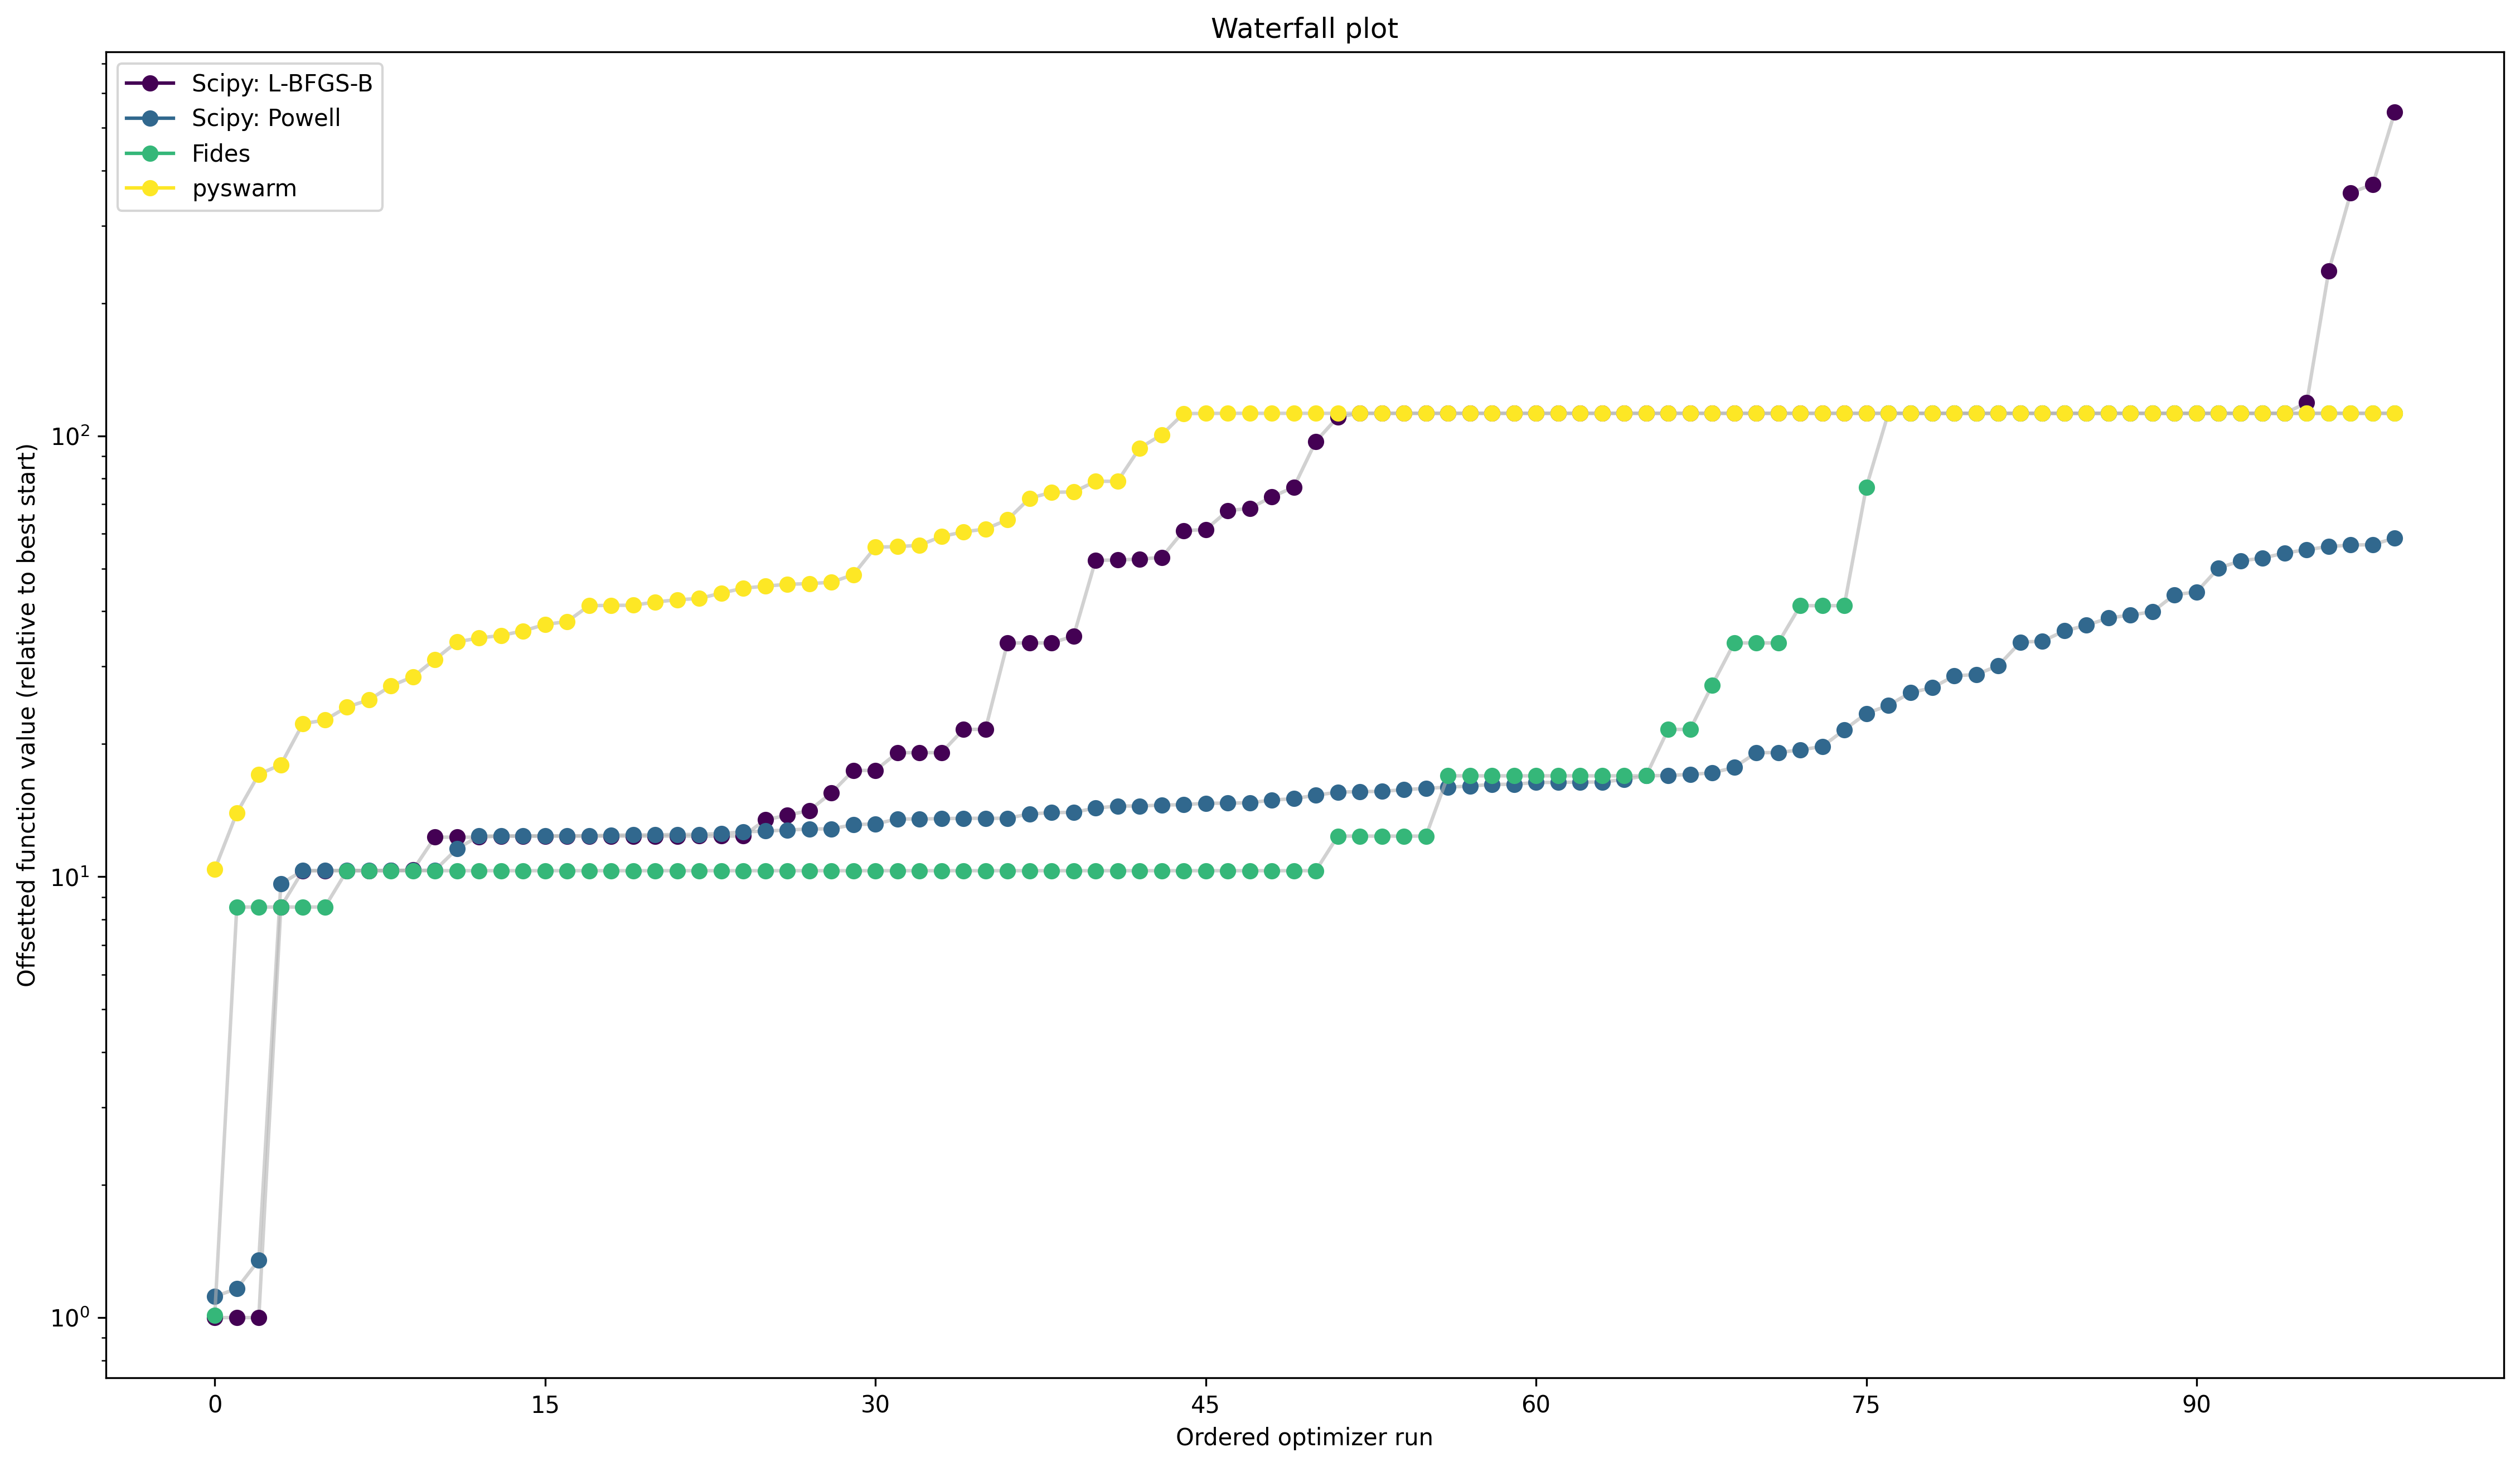

In [13]:
optimizer_results = [
    result_lbfgsb,
    result_powell,
    result_fides,
    result_pyswarm,
]
optimizer_names = ['Scipy: L-BFGS-B', 'Scipy: Powell', 'Fides', 'pyswarm']

pypesto.visualize.waterfall(optimizer_results, legends=optimizer_names);

## Optimizer run time

Optimizer run time vastly differs among the different optimizers, as can be seen below:

In [14]:
print('Average Run time per start:')
print('-------------------')

for optimizer_name, optimizer_result in zip(
    optimizer_names, optimizer_results
):
    t = np.sum(optimizer_result.optimize_result.get_for_key('time')) / n_starts
    print(f'{optimizer_name}: {t:f} s')

Average Run time per start:
-------------------
Scipy: L-BFGS-B: 3.357282 s
Scipy: Powell: 7.923657 s
Fides: 2.202625 s
pyswarm: 23.079163 s


## Fitting of large scale models

When fitting large scale models (i.e. with >100 parameters and accordingly also more data), two important issues are efficient gradient computation and parallelization.

### Efficient gradient computation

As seen in the example above and as can be confirmed from own experience: If fast and reliable gradients can be provided, gradients based optimizers are favourable with respect to omptimizer convergence and run time.  

It has been shown, that adjoint sensitivity analysis propose a fast and reliable method to compute gradients for large scale models, since their run time is (asymptotically) independent of the number of parameters ([Fröhlich et al. PlosCB 2017](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1005331&type=printable)).

In [15]:
# Set gradient computation method to adjoint
problem.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod.adjoint
)

## Parallelization

Multi-start optimization can easily be parallelized by using `engines`.

In [17]:
%%time
%%capture

# Parallelize
engine = pypesto.engine.MultiProcessEngine()

# Optimize
result = optimize.minimize(problem=problem, 
                           optimizer=optimizer_fides,
                           engine=engine,
                           n_starts=1000)

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 8 processes.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 64 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefe

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 129 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 68 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 2 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 164 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 101 failed: Specified hessian

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 134 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 73 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 169 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 106 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 7 failed: Specified hessian

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 173 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 77 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 139 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullMo

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 178 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 82 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 144 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 116 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 17 failed: Specified hessia

start 55 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 243 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 182 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 120 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in fol

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 60 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 248 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 187 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computat

start 257 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 95 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 222 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 30 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in fold

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 450 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 262 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 387 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 356 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 419 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/C

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 454 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 266 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 298 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 391 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in fo

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 302 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 427 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 395 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 364 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in fo

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 399 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 306 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 368 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 431 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in fo

start 435 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 310 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 372 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullM

start 502 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 345 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 283 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 471 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in fo

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 380 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 506 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 287 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 349 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 475 failed: Specified hess

start 516 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 704 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 548 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 641 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 673 failed: Specified hess

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 710 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 554 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 647 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullM

start 620 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 589 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 527 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 715 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 652 failed: Specified hess

start 625 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 594 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 720 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 564 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 532 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/C

start 629 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 724 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 536 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 568 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in fo

start 634 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 573 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 541 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 729 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 603 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/C

start 769 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 607 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 801 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullM

start 962 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 867 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 774 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 806 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 836 failed: Specified hess

start 779 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 967 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 872 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 811 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 841 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/C

start 973 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 817 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 878 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullM

start 916 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 791 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 853 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 884 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in fo

Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 859 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
start 890 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullModel.
start 986 failed: Specified hessian update scheme cannot be used with objectives that do not support Hessian computation.
Using existing amici model in folder /Users/jvanhoefer/Dokumente/PhD/Code/GitHub/DCM_Software/PESTO/current_develop/pyPESTO/doc/example/amici_models/FullM

CPU times: user 4.94 s, sys: 771 ms, total: 5.71 s
Wall time: 36.9 s


## Uncertainty quantification

PyPESTO focuses on two approaches to assess parameter uncertainties:

* Profile likelihoods
* Sampling

### Profile Likelihoods

[Profile likelihoods](https://academic.oup.com/bioinformatics/article/25/15/1923/213246) compute confidence intervals via a [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test). Profile likelihoods perform a maximum-projection of the likelihood function on the parameter of interest. The likelihood ratio test then gives a cut off criterium via the $\chi^2_1$ distribution.

In pyPESTO, the maximum projection is solved as maximization problem and can be obtained via

In [18]:
%%time
%%capture

import pypesto.profile as profile

result = profile.parameter_profile(problem=problem, 
                                   result=result, 
                                   optimizer=optimizer_fides)

AttributeError: 'NoneType' object has no attribute 'shape'

CPU times: user 105 ms, sys: 6.41 ms, total: 112 ms
Wall time: 114 ms


The maximum projections can now be inspected via:

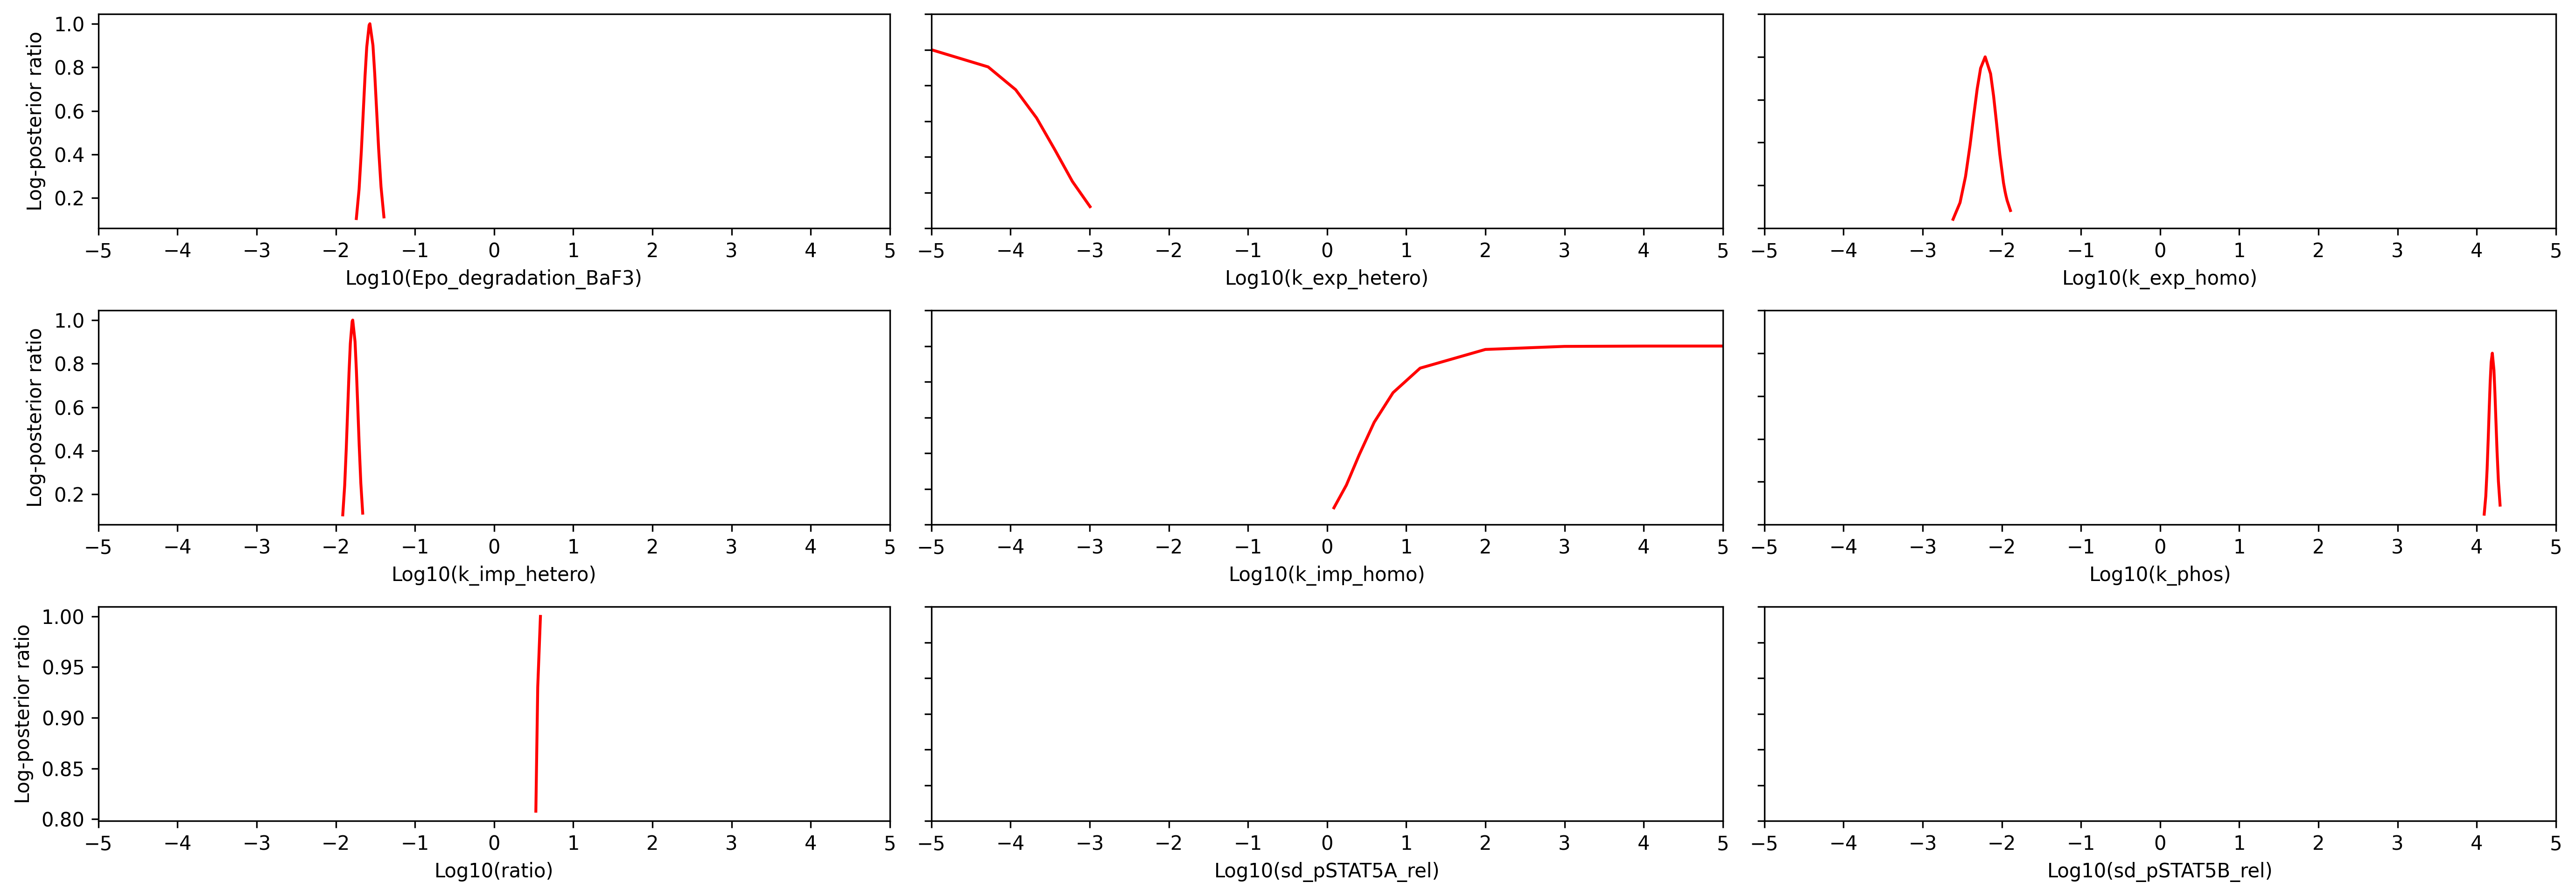

In [29]:
# adapt x_labels..
x_labels = [f'Log10({name})' for name in problem.x_names]

visualize.profiles(result, x_labels=x_labels, show_bounds=True);

The plot shows that seven parameters are identifiable, since the likelihood is tightly centered around the optimal parameter. Two parameters (`k_exp_hetero` and `k_imp_homo`) can not be constrained by the data.

Furthermore pyPESTO allows to visualize confidence intervals directly via

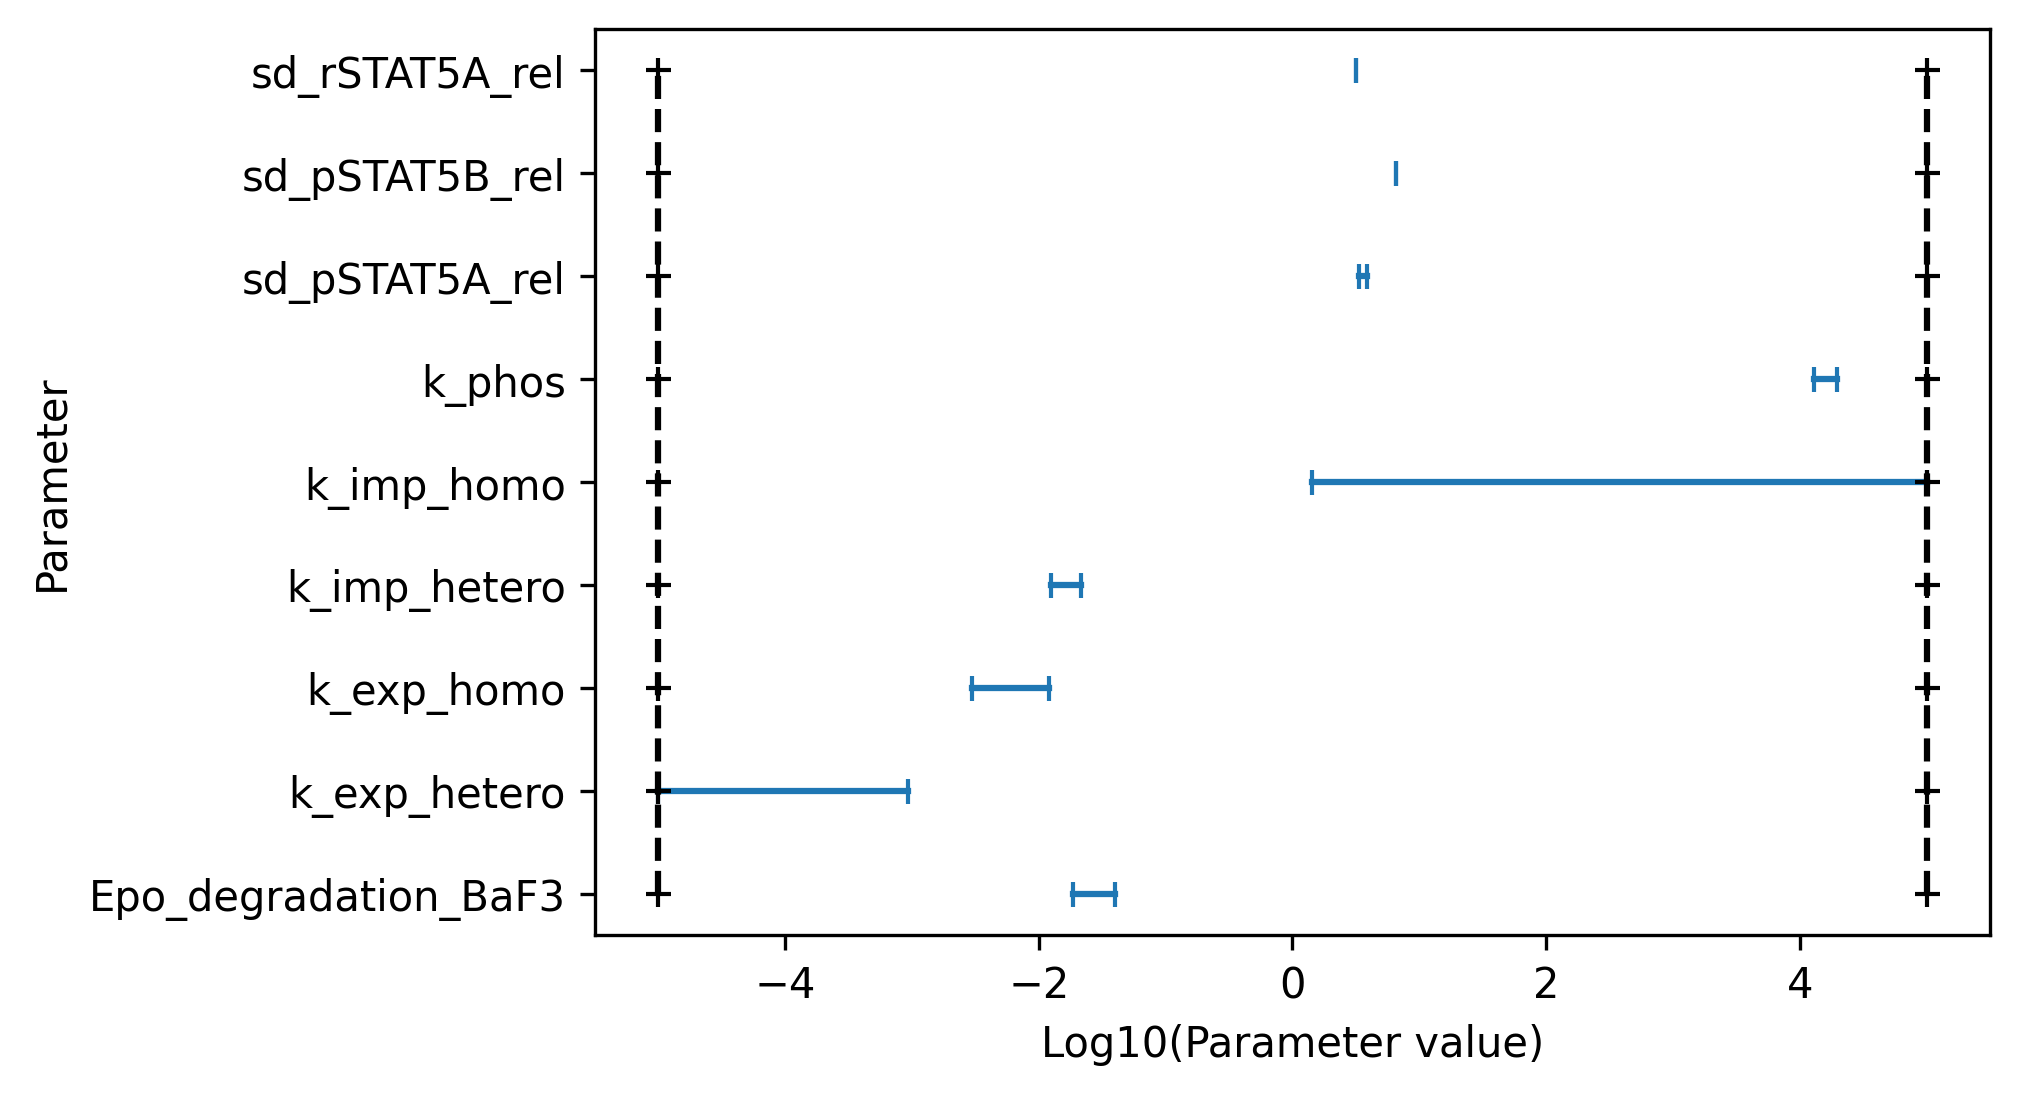

In [30]:
ax = pypesto.visualize.profile_cis(
    result, confidence_level=0.95, show_bounds=True
)

ax.set_xlabel('Log10(Parameter value)');

### Sampling

In pyPESTO, sampling from the posterior distribution can be performed as 

In [31]:
import pypesto.sample as sample

n_samples = 10000

sampler = sample.AdaptiveMetropolisSampler()

result = sample.sample(
    problem, n_samples=n_samples, sampler=sampler, result=result
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 563.04it/s]
Elapsed time: 22.231136000000006


Sampling results are stored in `result.sample_result` and can be accessed e.g. via

In [32]:
result.sample_result.trace_x

array([[[-1.56906993, -5.        , -2.20985387, ...,  4.19770467,
          0.8188605 ,  0.49860135],
        [-1.56906993, -5.        , -2.20985387, ...,  4.19770467,
          0.8188605 ,  0.49860135],
        [-1.56906993, -5.        , -2.20985387, ...,  4.19770467,
          0.8188605 ,  0.49860135],
        ...,
        [-1.58083569, -4.98619455, -2.26191612, ...,  4.21435671,
          0.84363936,  0.58862664],
        [-1.60267101, -4.9937955 , -2.15419716, ...,  4.19110774,
          0.76369894,  0.49059349],
        [-1.60267101, -4.9937955 , -2.15419716, ...,  4.19110774,
          0.76369894,  0.49059349]]])

### Samlping Diagnostics

Gewekes test accesses convergence of a sampling run and computes the burn in of a sampling result. The effective sample size indicates the strenght the correlation between different samples.

In [33]:
sample.geweke_test(result=result)
result.sample_result['burn_in']

Geweke burn-in index: 0


0

In [34]:
sample.effective_sample_size(result=result)
result.sample_result['effective_sample_size']

Estimated chain autocorrelation: 730.3192806709271
Estimated effective sample size: 13.67528556176569


13.67528556176569

### Visualization of Sampling Results

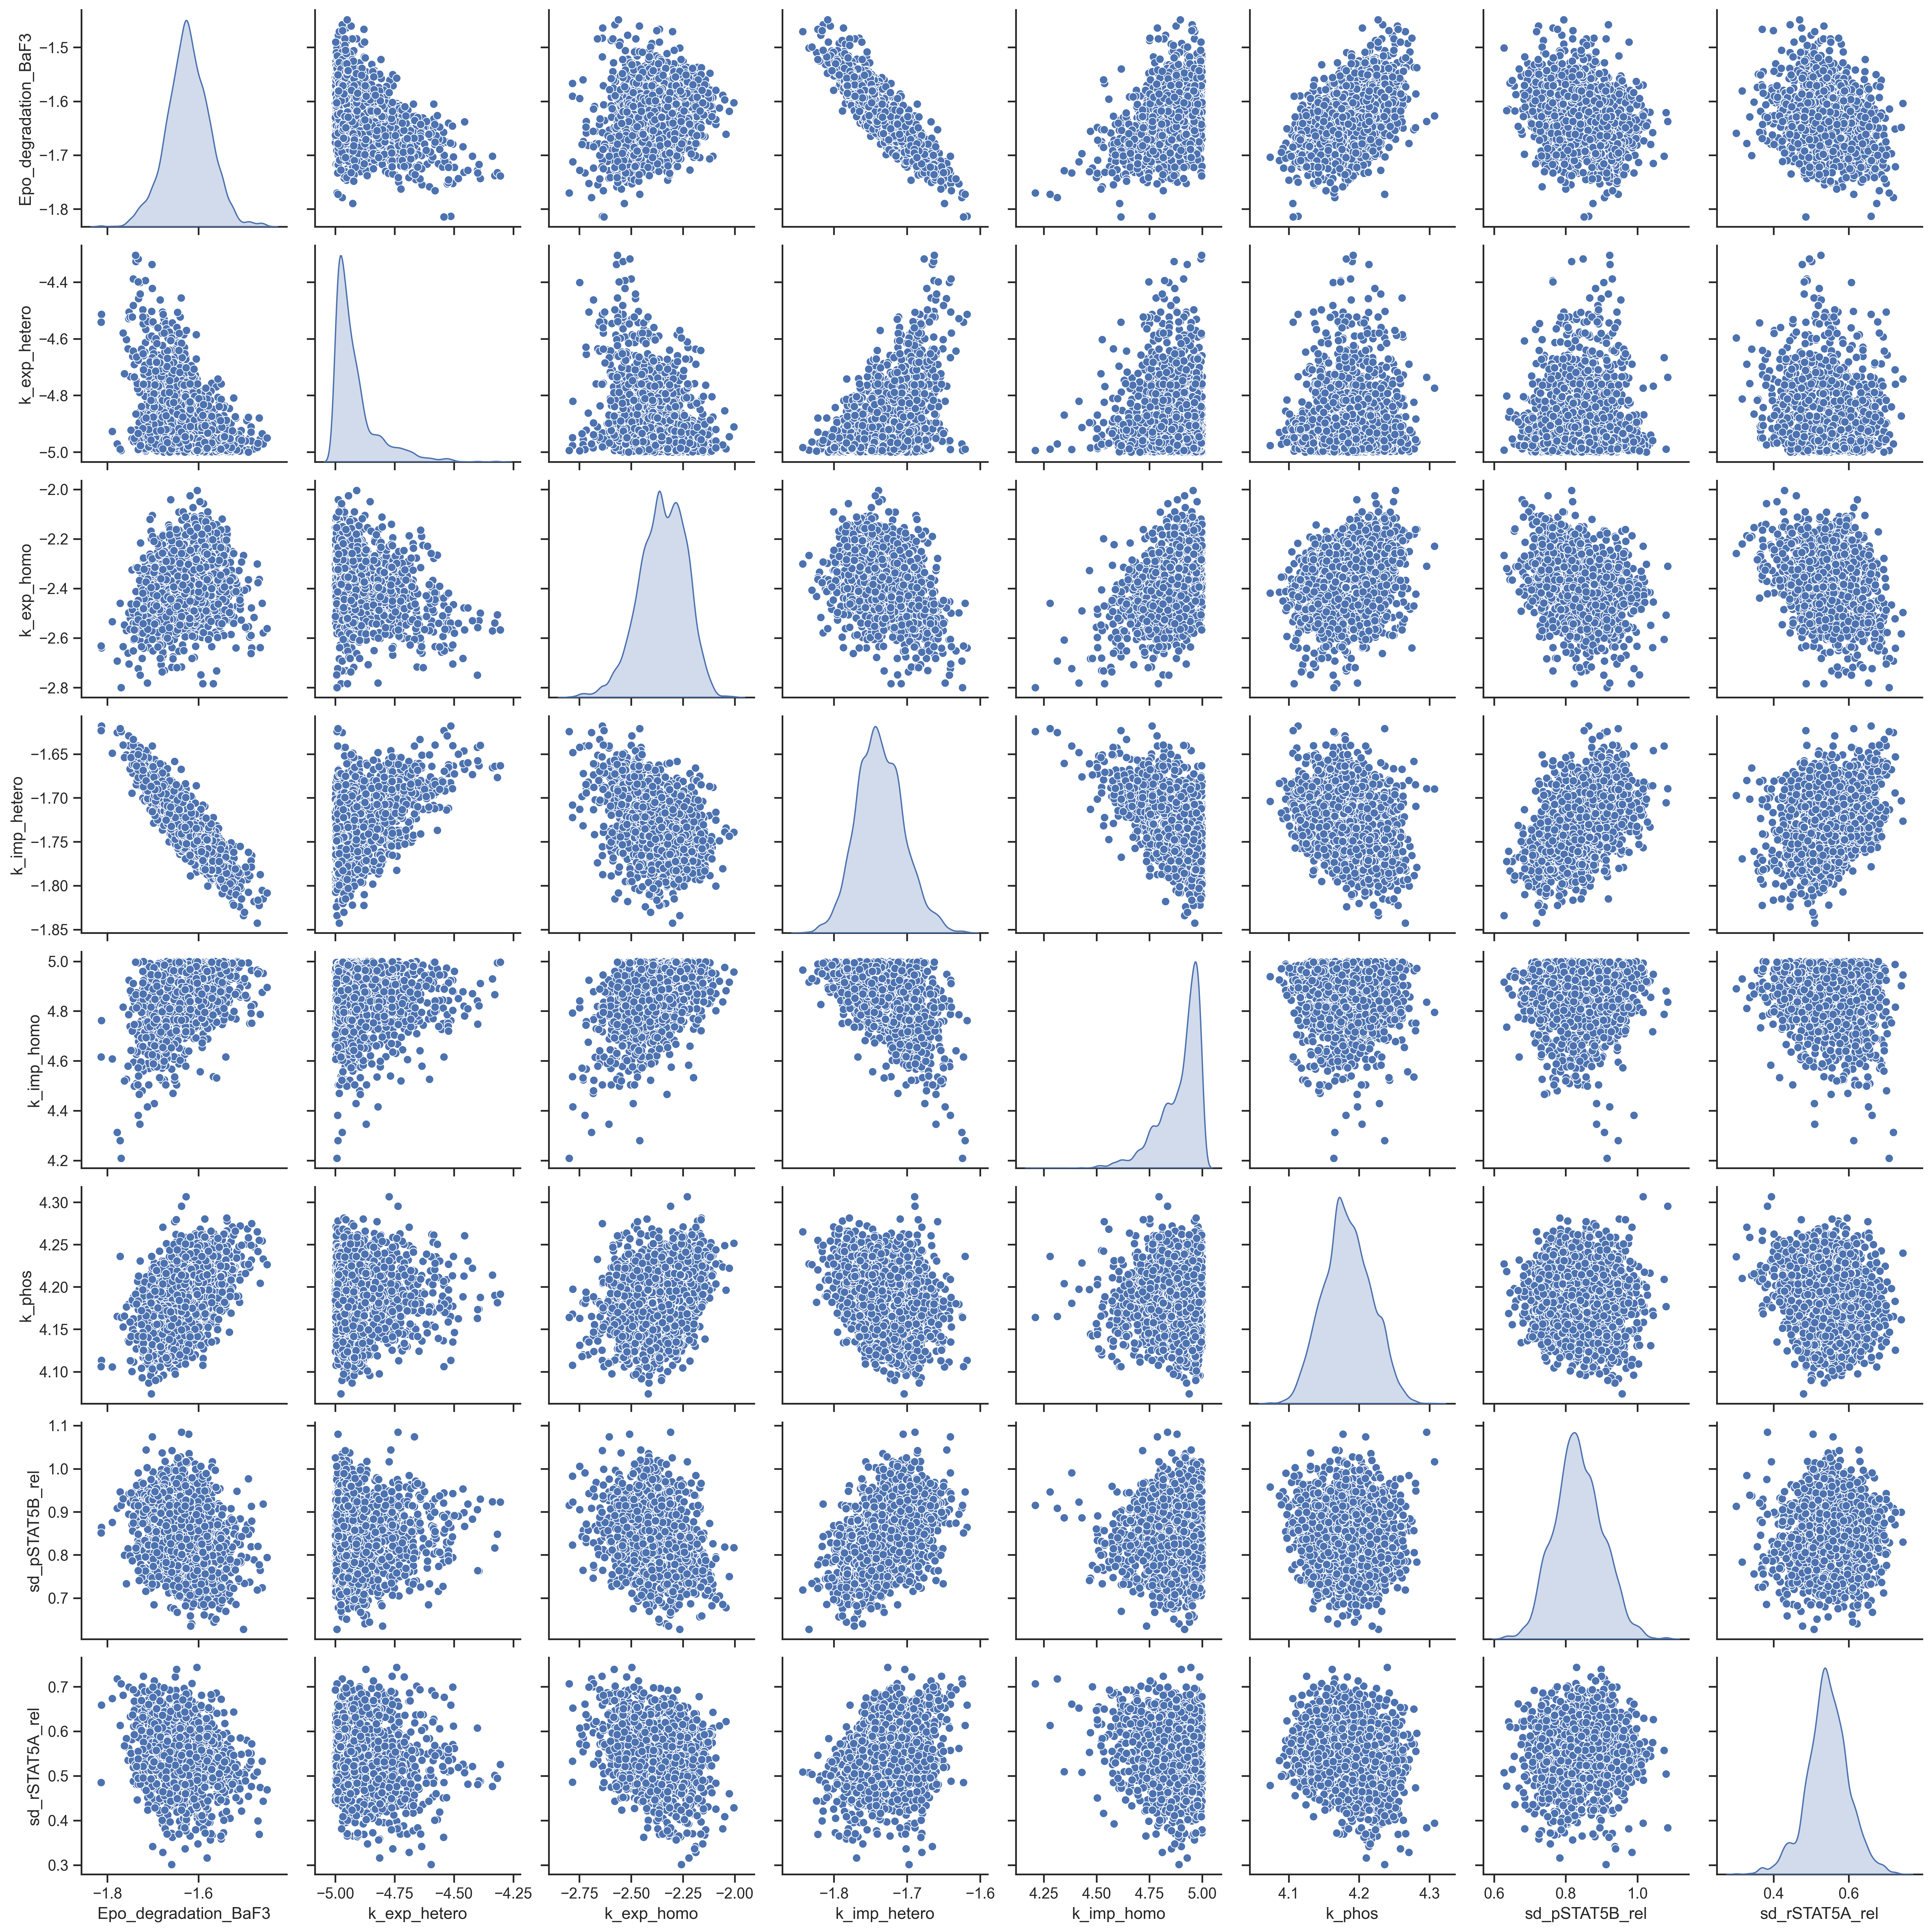

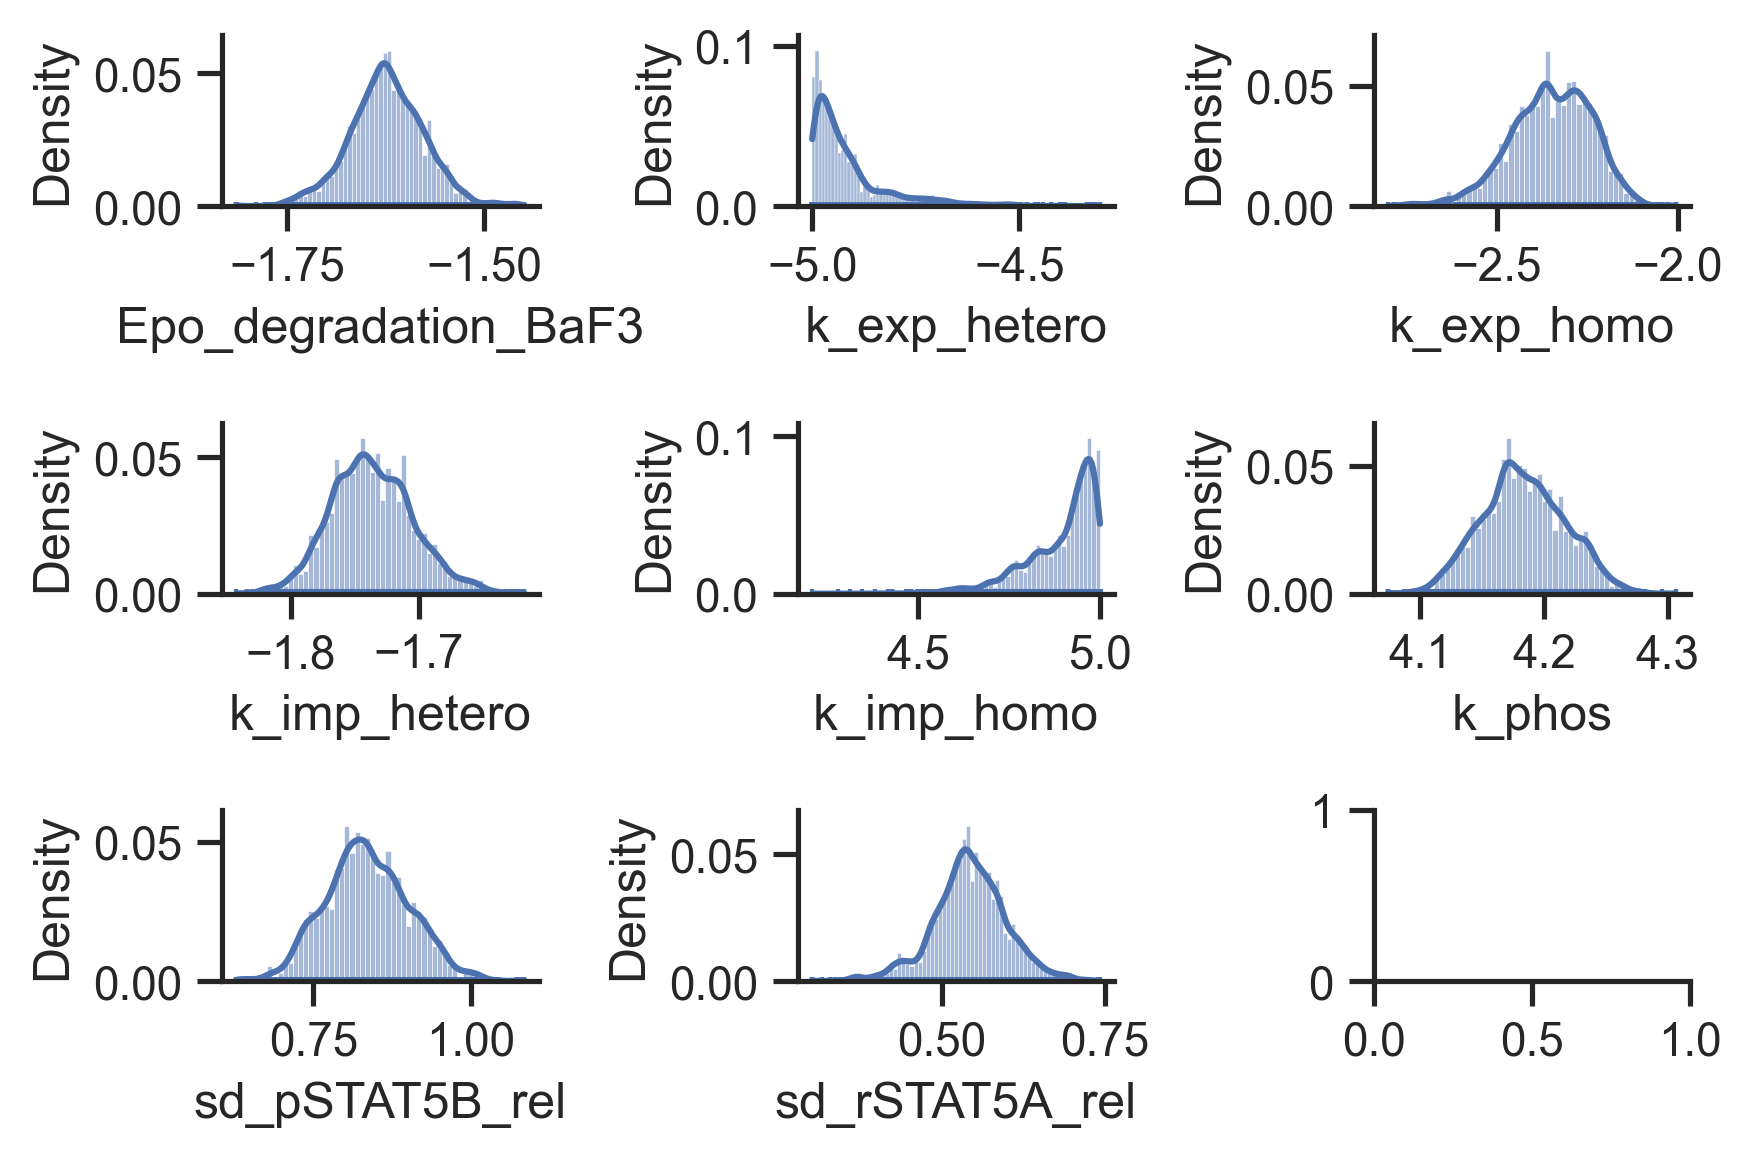

In [35]:
# scatter plots
ax = visualize.sampling_scatter(result)

# marginals
ax = visualize.sampling_1d_marginals(result)

### Sampler Choice:

Similarly to parameter optimization, pyPESTO provides a unified interface to several sampler/sampling toolboxes, as well as own implementations of sampler:

* Adaptive Metropolis:   `sample.AdaptiveMetropolisSampler()`
* Adaptive parallel tempering:   `sample.ParallelTemperingSampler()`
* Interface to `pymc3` via `sample.Pymc3Sampler()`

## Software Development Standards:

PyPESTO is developed with the following standards:

* **Open source**, code on [GitHub](https://github.com/ICB-DCM/pyPESTO).
* [**Pip installable**](https://pypi.org/project/pypesto/) via: `pip install pypesto`.
* **Documentation** as [RDT](https://pypesto.readthedocs.io/en/stable/) and [example **jupyter notebooks**](https://github.com/ICB-DCM/pyPESTO/tree/master/doc/example) are available.
* Has **continous integration** & extensive automated **testing** via travis.
* **Code reviews** before merging into the develop/master branch.

* Currently **5-10 people are using, extending** and (most importantly) **maintaining** pyPESTO in their "daily business".

## Further functionality of pyPESTO

Further aspects covered in pyPESTO:

* **Ensemble Predictions**
* Generation of **synthetic data** for pipeline testing
* **Model Selection**
* **Categorial Data** (see the corresponding GitHub branch)

Future extension currently developed include:

* **Experimental Design**
* **Hierarchical Optimization** of scaling/noise parameters
* ...